# Проект №3: Исследование объявлений о продаже квартир



## Цели и задачи проекта

### Цель проекта
Предоставить результаты первичного исследования статистических данных для построения модели определения соответствия заявленной стоимости объекта недвижимости остальным параметрам объекта недвижимости

### Задачи проекта
1. Выявить параметры с сильным влиянием на цену объекта недвижимости
2. На их основе исследовать сегментацию цен
3. Определить какую цену считать рыночной в данном сегменте объектов недвижимости
4. Исследовать влияние дополнительных параметров - близости аэропорта и зеленых зон
5. Рассмотреть возможность использования временных параметров - времени экспозиции и даты размещения

### Первые идеи

* При исследовании данных нужно определиться для какой сегментации данных достаточно - недостаточные, но важные данные можно будет использовать для трендов зависимостей: то есть имея сегмент объектов можно брать среднюю цену, затем от средних значений каждой трендовой величины вычислять поправку по производной, также усредненной по сегменту (мы говорим об усреднении без уточнения метода: mean, median, с определяемыми анализом весами - это станет ясно потом)

* В целом такой подход похож на решение задачи малыми возмущениями: мы берем за нулевое преближение цены, которые могут быть сегментированы (полнота данных после предобработки позволяет определить сегмент для каждой записи), после этого мы вычисляем поправки на дополнительные параметры, по которым данные не полны, но можно по части записей посчитать тренд.  В линейном приближении считаем влияния независимых доппараметров простым сложением.  В итоге получим предсказываемый ценовой параметр как: $$ P_{predicted} = P_0(сегмент) + P_1(доп.параметры)$$

* Таким образом, уже при предобработке данных нужно классифицировать их по применимости к: 
 * сегментации цены
 * расчету цены за квадратный метр
 * заполнению пробелов данных типичными значениями по группе объектов
 * расчету бонусного тренда внутри сегментов
 * интегральной важности для анализа (мотивация к затрату больших усилий по качественному заполнению пробелов)


## Предобработка данных

### Первичное ознакомление с данными

#### Исходная таблица данных
Данные представляют себе csv-файл с информацией сервиса Яндекс Недвижимость — табличный архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет:

In [1]:
import pandas as pd

raw_df = pd.read_csv('datasets/real_estate_data.csv', sep='\t') # проверка notepad-ом показала, что данные разделены табуляцией

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Имеются разъяснения по семантике данных в каждом столбце.

**Описание данных:** *(упорядочено в соответствии с порядком столбцов в датасете, немедленные замечания предваряются "**SAA**")*

0. `total_images         —` число фотографий квартиры в объявлении
1. `last_price           —` цена на момент снятия с публикации
2. `total_area           —` площадь квартиры в квадратных метрах (м²)
3. `first_day_exposition —` дата публикации *(**SAA:** в таблице тип `object`)*
4. `rooms                —` число комнат
5. `ceiling_height       —` высота потолков (м)
6. `floors_total         —` всего этажей в доме *(**SAA:** в таблице тип `float`)*
7. `living_area          —` жилая площадь в квадратных метрах (м²)
8. `floor                —` этаж
9. `is_apartment         —` апартаменты (булев тип) *(**SAA:** а в таблице тип `object`)*
10. `studio               —` квартира-студия (булев тип)
11. `open_plan            —` свободная планировка (булев тип)
12. `kitchen_area         —` площадь кухни в квадратных метрах (м²)
13. `balcony              —` число балконов *(**SAA:** в таблице тип `float`)*
14. `locality_name        —` название населённого пункта
15. `airports_nearest     —` расстояние до ближайшего аэропорта в метрах (м)
16. `cityCenters_nearest  —` расстояние до центра города (м) *(**SAA:** не понятно, это до центра Питера или до центра нас.пункта ?!)*
17. `parks_around3000     —` число парков в радиусе 3 км *(**SAA:** в таблице тип `float`)*
18. `parks_nearest        —` расстояние до ближайшего парка (м)
19. `ponds_around3000     —` число водоёмов в радиусе 3 км *(**SAA:** в таблице тип `float`)*
20. `ponds_nearest        —` расстояние до ближайшего водоёма (м)
21. `days_exposition      —` сколько дней было размещено объявление (от публикации до снятия) *(**SAA:** в таблице тип `float`)*

В названиях и в типах данных наблюдаются некоторые недостатки. Недостатки с именованием исправляем сразу.  С конверсией типов так быстро не получилось из-за отсутствующих значений - отложим до детального изучения каждого столбца. 


In [2]:
raw_df = raw_df.rename(
    columns = {
        'studio':'is_studio',
        'open_plan':'is_open_plan',
        'balcony':'balconies',
        'airports_nearest':'airport_nearest',
        'parks_nearest':'park_nearest',
        'ponds_nearest':'pond_nearest',
        'cityCenters_nearest':'city_center_nearest'
    }
)

#### таблица данных с коррекцией имен столбцов: 

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  is_studio             23699 non-null  bool   
 11  is_open_plan          23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balconies             12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airport_nearest    

**Также известно,** что по каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Посмотрим на полные дупликаты в исходном датафрейме:

In [4]:
raw_df.duplicated().value_counts()

False    23699
dtype: int64

полные дупликаты в исходном дата фрейме отсутствуют

### Выводы после предварительного ознакомления с данными и их сопоставления с целями и задачами проекта

1. В таблице нет достоверных данных о цене фактической продажи объекта недвижимости.  Поэтому все цены являются субъективными пожеланиями авторов объявлений.  Как известно, реальные цены продаж отличаются от цен объявлений - причем, чем хуже продажи, тем сильнее отличие: в кризисы разница достигает 15 %.  Таким образом, данные не позволяют буквально "определять рыночную стоимость объектов недвижимости".  Например, в кризис объявления не отражают кризисное временное падение стоимости недвижимости (а цены реальных продеж - отражают).  Но можно считать что у цены объекта недвижимости есть несколько параметров, и один из них, оценку стоимости объекта в объявлении, мы, фактически только и сможем проанализировать.  После данного замечания будем далее кратко именовать его ценой. 

2. В таблице нет даже информации о том, состоялась ли сделка.  Поэтому даже косвенный параметр времени экспозиции, позволяющий косвенно судить о близости цены к рыночной, не является достоверным.

3. В таблице присутствуют странные параметры близости к аэропорту, паркам и прудам, но отсутствует расстояние до станции метро/пригородной электрички и название ветки метро/пригородного сообщения.

4. Расстояние до центра города также должно измераться не в километрах, а в минутах езды общественным транспортом - в различных микрорайонах ситуация разная, даже на одинаковом гео-расстоянии от центра.

5. Общеизвестно, что во всех крупных городах мира стоимость недвижимости определяется районом города/пригорода - есть дорогие, есть дешевле.  На примере Москвы можно сказать, что объединять одним расстоянием до центра Строгино и Жулебино, или Рублевку и Мытищи, неверно.  В Питере должно быть еще сложнее - из-за реки и мостов. В таблице отсутствует параметр района, для пригорода его роль частично может исполнить название населенного пункта.

6. В таблице нет типа многоквартирного дома и года его постройки - очень существенный параметр цены жилой недвижимости в крупном городе

7. Нет информации о наличии автостоянки на территории дома и о закрепленности места на ней за объектом (ее платности/бесплатности и пр)

8. Можно предположить, что в таблице присутствует только жилая недвижимость, дупликатов объявлений нет.

**Резюме:** данные таблицы можно признать удовлетворительными только в части метрических и инвентарных параметров объектов.  В качестве других факторов цены выступает группа гео-картографических параметров (растояния по карте), решение использовать которые вызывает вопросы у любого риэлтера.  Отсутствует ряд важных параметров (см. выше пп.3-7), наиболее сильно влияющих на ценовой диапазон объектов недвижимости на практике.  Это означает, что зависимости от других факторов цены могут быть сильно усреднены между ценовыми нишами и слабы.

### Детальное изучение столбцов данных 

#### `0. total_images` - число фотографий квартиры в объявлении

In [5]:
raw_df['total_images'].value_counts().sum() # сколько ненулевых записей

23699

In [6]:
raw_df['total_images'].value_counts().head(10) # кол-во вариантов ожидается сильно ограниченным, поэтому вызов value_counts()

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
Name: total_images, dtype: int64

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = нет, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = отсутствует

**Вывод:** значения присутствуют во всех записях.  Тип данных (int64) соответствует семантике. Источник информации - автор объявления.  Данный параметр мало соотносится с целями нашего исследования - фотографии помогают только сократить срок первых просмотров жилья.  Возможно, отсутствие таковых является сигналом к недобросовестному объявлению.

**Замечено:** в 1059 из 23699 записях фотографий нет (4,5 %) - присутствует значение 0. 

**Дальнейшая предобработка** не требуется.  Возможно будет перед началом анализа заменить на категорию `enough_photos`:
* `отсутствуют - ` значение 0,
* `мало        - ` меньше чем число комнат + кухня (1 фото) и санузел (2 фото),
* `много       - ` больше чем число комнат + 3.


#### `1. last price` - цена на момент снятия с публикации

In [7]:
raw_df['last_price'].value_counts().sum() # сколько ненулевых записей

23699

In [8]:
raw_df['last_price'].value_counts().head() # кол-во уникальных ожидается огромным, поэтому выводим минимально строк результата

4500000.0    342
3500000.0    291
4000000.0    260
4300000.0    260
4200000.0    259
Name: last_price, dtype: int64

это один из самых интересных параметров анализа, поэтому сразу глянем на данные поближе (пока не делим объявления по кол-ву комнат)

In [9]:
raw_df['last_price'].describe() # можно было сразу вызвать describe(), но из-за степенной формы трудно воспринимать сразу

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

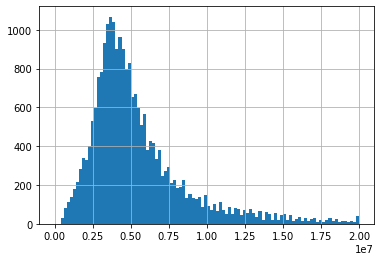

In [10]:
raw_df['last_price'].hist(bins=100, range=(0,20_000_000))

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = да, 
* тип объекта = нет, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = максимальна

**Вывод:** значения присутствуют во всех записях.  Тип данных (float64) соответствует семантике. Источник информации - автор объявления. Распределение Пуассоновского типа, что вселяет надежду на достоверность самих данных.  Однако данная информация не является объективным параметром объекта - это субъективные ожидания + желания автора объявления.  Согласно цели проекта, построение объективной оценки данной информации и является задачей исследования.

**Замечено:** средние цены соответствуют разумным ожиданиям по столичной недвижимости, минимальные цены недостоверны (12 000 руб), но возможно, они указаны в у.е.   

Дальнейшая предобработка не требуется.  Так как существует годовая динамика цены, то при вычислении средних ценовых показателей рекомендуется усреднять с весами, учитывающими среднюю динамику цен по годам.

#### `2. total_area` - площадь квартиры в квадратных метрах (м²)

In [11]:
raw_df['total_area'].describe() # здесь формат обычный, поэтому сразу вызов describe(). Ожидается много уникальных значений 

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = да (скорее всего будем предсказывать стоимость квадратного метра в каждом сегменте), 
* тип объекта = да, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = максимальна

**Вывод:** значения присутствуют во всех записях.  Тип данных (float64) соответствует семантике. Источник информации - автор объявления. 

**Замечено:** Более половины по метражу похожи на 1-2-3-комнатные квартиры, минимальные площади больше походят на комнаты, максимальные - на частные загородные дома.  В целом цифры разумные.

Дальнейшая предобработка не требуется.

#### `3. first_day_exposition` - дата публикации

In [12]:
raw_df['first_day_exposition'].value_counts().sum() # проверяем все ли ненулевые

23699

In [13]:
raw_df['first_day_exposition'].head() # смотрим формат даты-времени

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
Name: first_day_exposition, dtype: object

сразу приведем к типу данных `datetime`:

In [14]:
raw_df['first_day_exposition'] = pd.to_datetime(raw_df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
raw_df['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

In [15]:
raw_df['first_day_exposition'].describe(datetime_is_numeric=True) # после приведения типа будет информативнее вызов describe()

count                            23699
mean     2017-11-08 21:55:18.975484160
min                2014-11-27 00:00:00
25%                2017-05-12 12:00:00
50%                2017-12-12 00:00:00
75%                2018-08-26 00:00:00
max                2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

<AxesSubplot:>

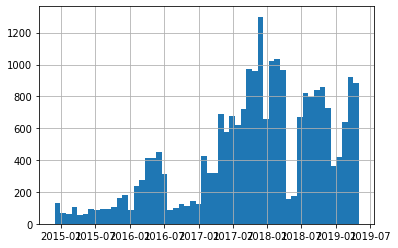

In [16]:
raw_df['first_day_exposition'].hist(bins=54)  # посмотрим динамику сервиса за весь период (1 bin ~ 1 мес)

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = да (вместе с временем экспозиции дает дату последней цены), 
* тип объекта = нет, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = существенная

**Вывод:** значения присутствуют во всех записях.  Тип данных успешно приведен к соответствию семантике (pandas.datetime). Источник информации - регистрация объявлений (достоверный). 

**Замечено:** Объявления за период чуть менее 4.5 года: с 27-ноя-2014 по 03-мая-2019.  Большая часть приходится на вторую половину периода. Кстати, из диапазона следует, что наше исследование даст предсказание цены на 2-ю половину 2019 года

Предобработка проведена.

#### `4. - rooms` - число комнат

In [17]:
raw_df['rooms'].value_counts().sum()

23699

In [18]:
raw_df['rooms'].value_counts() # так как уникальных значений ожидается мало, то смотрим все

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Большинство 1-2-3-4 комнатные квартиры, есть загадочная категория в 0 комнат - ее сейчас посмотрим поближе, 6+ комнат похоже на загородные дома, 5 комнат - пограничное значение, надо посмотреть детальнее куда их отнести.

Начнем с понимания, что за объекты с нулем комнат - проверим гипотезу, что это свободная планировка или студио:

In [19]:
raw_df.query('(rooms == 0) & ((is_studio)|(is_open_plan))')['rooms'].count()

197

Упс! Все rooms == 0 являются либо студиями, либо свободной планировкой!  В отношении студио оптимально будет добавить их все к rooms == 1, а категоризацию оставить за значением is_studio.  А вот с открытой планировкой сложнее - их можно раскидать по метражу: 

In [20]:
raw_df.loc[raw_df['is_open_plan'], 'rooms'].value_counts() # сколько бывает комнат в объявлениях со свободной планировкой

0    59
1     3
3     2
2     1
4     1
5     1
Name: rooms, dtype: int64

**Роль:** 
* ценовой сегмент = да, 
* расчет средних цен = нет, 
* тип объекта = да, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = максимальна

**Вывод:** значения присутствуют во всех записях.  Тип данных (int64) соответствует семантике. Источник информации - автор объявления. 

**Замечено:** порядка 200 объектов указаны как 0 комнат, все они либо студио, либо с открытой планировкой. Записи с числом комнат от 10 не представляют никакой статистической достоверности - их единицы. Объекты, начиная с 5 комнат и более малочисленны - в сумме с нулевыми составляют ровно 2.2 % от записей всей таблицы, а начиная с 8 комнат - вообще единичны, поэтому: 

**Решение об удалении записей:** 
* сперва заполняем все 0 значениями в зависимости от того, является ли объект студио или открытой планировкой. 
* затем меняем все 6 и 7 на 5 - это будет рассматриваться как категория '5+'. 
* В конце предобработки в датасете для анализа оставим только `rooms in (1,2,3,4,5)`, где 5 станет категорией многокомнатных (5,6,7) объектов.

Замену значений делаем сразу, удаление хвостов - в завершении предобработки с остальными удалениями:

In [21]:
def zero_rooms_subs(df): # функция заменяет нулевые значения rooms, оставляя прежними все другие
    
    studio = df['is_studio']
    open_plan = df['is_open_plan']
    area = df['total_area']
    old_value = df['rooms']
    
    if old_value != 0: return old_value
    
    if studio: return 1
    elif open_plan:
        if area < 45.0: return 1
        elif area < 65.0: return 2
        elif area < 85.0: return 3
        elif area < 110: return 4
        else: return 5
    else: return 0 # смена значения не удалась

def mult_rooms_subs(r):
    if r not in (6,7): return r
    else: return 5
    
raw_df['rooms'] = raw_df.apply(zero_rooms_subs, axis=1) # сперва заменим нули

raw_df['rooms'] = raw_df['rooms'].apply(mult_rooms_subs) # теперь объединяем 5,6,7 комнат в одну категорию 5="многокомнатный"

raw_df['rooms'].value_counts() # посмотрим результат

1     8243
2     7940
3     5814
4     1180
5      491
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

оставшиеся хвосты 8+ комнат потом просто удалим - это составит 0,13% от всех записей.  отметим также, что почти все с открытой планировкой и rooms == 0 попали в rooms == 1.

#### `5. ceiling_height` - высота потолков (м)

In [22]:
raw_df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

минимальное и максимальное значения нереальны, причем максимальное не годится и в предположении, что по ошибке указали в сантиметрах.  Посмотрим много ли их.  Возьмем за разумные границы высоты потолков от 2 до 4 метров:

In [23]:
raw_df.query('(ceiling_height < 2.0) | (ceiling_height > 4.0)')['ceiling_height'].count()

78

**Роль:** 
* ценовой сегмент = да (например, в пятиэтажках можно разделять хрущебы и сталинки, однако слишком мало данных для сегментации, возможно использовать как бонус цен), 
* расчет средних цен = нет, 
* тип объекта = да, 
* дополнительный бонус к цене = да (правильнее использовать в сегментации, но данные слишком неполны!), 
* нужность для задач проекта = существенна

**Вывод:** значения отсутствуют в 1-14504/23699 = 38.8 % части объявлений. Тип данных (float64) соответствует семантике. Источник информации - автор объявления.

**Замечено:** Всего 78 из 14504 ненулевых записей (0.5%) высоты потолков выходят за пределы диапазона 2-4 метра.  Их можно было бы удалить.  Восстановить отсутствующую часть информации (38.8 % всех объявлений) по другим параметрам записей не представляется возможным, так как нет ни типа дома, ни конкретного адреса - по которым можно было бы найти значения в других записях.  Можно предположить, что этажность дома хорошо коррелирует с типом дома и что у домов, скажем, 22 этажа одинаковая высота потолка, но в диапазоне 3-9 этажек это сильно различается - от "сталинок" с 3.5м до "хрущевок" с 2.4м

**Решение об удалении записей**: пока удаляем только хвосты (78 записей) - так как непонятно что делать с отсутствующими записями 38.8%  - есть слабая идея заполнить их средним по этажности домов.

проверим еще одну идею - полноту данных по пятиэтажкам и ниже, так как именно там большой разброс типов домов

In [24]:
for h in range(1,int(raw_df['floors_total'].max())):
    data_missing_share = raw_df[raw_df['floors_total'] == h]['ceiling_height'].isna().mean()
    if data_missing_share >= 0.0: # выбросим NaN для домов с отсутствующей в данных этажностью
        print(f'Для {h}-этажных домов отсутствует {round(data_missing_share*100,1)}% данных')

Для 1-этажных домов отсутствует 60.0% данных
Для 2-этажных домов отсутствует 43.9% данных
Для 3-этажных домов отсутствует 40.3% данных
Для 4-этажных домов отсутствует 34.2% данных
Для 5-этажных домов отсутствует 36.7% данных
Для 6-этажных домов отсутствует 32.3% данных
Для 7-этажных домов отсутствует 32.8% данных
Для 8-этажных домов отсутствует 43.6% данных
Для 9-этажных домов отсутствует 32.0% данных
Для 10-этажных домов отсутствует 36.1% данных
Для 11-этажных домов отсутствует 46.3% данных
Для 12-этажных домов отсутствует 37.4% данных
Для 13-этажных домов отсутствует 48.9% данных
Для 14-этажных домов отсутствует 38.0% данных
Для 15-этажных домов отсутствует 38.4% данных
Для 16-этажных домов отсутствует 37.1% данных
Для 17-этажных домов отсутствует 39.6% данных
Для 18-этажных домов отсутствует 45.5% данных
Для 19-этажных домов отсутствует 60.5% данных
Для 20-этажных домов отсутствует 42.4% данных
Для 21-этажных домов отсутствует 58.9% данных
Для 22-этажных домов отсутствует 50.7% данн

увы, но идея использовать данный параметр для сегментации старых малоэтажек (отличать "хрущебы", "брежневки" и "сталинки") не поддерживается данными - в малоэтажном сегменте также отсутствует порядка 40% данных о высоте потолков.  Поэтому, к сожалению, использовать данный параметр для сегментации не получится - сможем рассмотреть его только как бонус к цене (взяв тренд на 60% выборке с присутствующими данными по сегментам)

#### `6. floors_total` - всего этажей в доме

In [25]:
raw_df['floors_total'].value_counts().sum()

23613

данные по данному столбцу отсутствуют в 86 записях из 23699 (0.36 %).  Посмотрим на них:

In [26]:
raw_df[raw_df['floors_total'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balconies,locality_name,airport_nearest,city_center_nearest,parks_around3000,park_nearest,ponds_around3000,pond_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


отсутствие данных об этажности дома лишает данные записи возможности категоризации *первый-последний этаж*, что является важным фактором цены.  Кроме того, как уже говорилось, этажность дома - единственный параметр, косвенно связанный с типом дома - также является важным фактором цены.  Проще выбросить эти 86 записей, чтобы не мешали поиску зависимостей по данному параметру.

In [27]:
raw_df['floors_total'].value_counts() # ожидается ограниченное число вариантов, поэтому смотрим весь вывод

5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
37.0       1
34.0       1
33.0       1
60.0       1
29.0       1
52.0       1
Name: floors_total, dtype: int64

вариантов больше, чем ожидалось, но от 28 отчетливо виден хвост с единичными количествами:

In [28]:
raw_df[raw_df['floors_total']>27]['floors_total'].count() # посчитаем сколько записей в хвосте

54

этажность от 28 и выше можно также выбросить из-за малости такой выборки - 54 значения (0.23 %)

**Роль:** 
* ценовой сегмент = да (после категоризации), 
* расчет средних цен = нет, 
* тип объекта = да, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = существенная

**Вывод:** значения отсутствуют всего в 0.36% всех записей. Тип данных (float64) целесообразно привести к int. Источник информации - автор объявления.  Этажность дома - единственный присутствующий параметр, косвенно связанный с типом дома (особенно хорошо это заметно в стандартных топовых значениях 5, 9, 12 и 16 этажей), поэтому весь диапазон от 2 до 27 этажей может иметь разные стат-характеристики цены. 

**Замечено:** многоэтажные башни (от 28 этажей и выше) представлены крайне редко - в 0.23% всех объявлений.  Одноэтажных домов также недостаточно для статистики.

**Решение об удалении записей:** после завершения постолбцового анализа удаляем оба вида записей - с NaN и с этажностью 1 и от 28 этажей, что составит потерю 0.6% всех записей.  Тип будет проще привести к int после удаления NaN

#### `7. living_area` - жилая площадь в квадратных метрах (м²)

In [29]:
raw_df['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = да (в комбинации с кол-вом комнат, этажностью, общей площадью), 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = полезна

**Вывод:** значения отсутствуют в 8.0% всех записей.  Тип данных (float64) соответствует семантике. Источник информации - автор объявления. 

**Замечено:** Более половины по метражу похожи на 1-2-3-комнатные квартиры, минимальные площади больше походят на комнаты, максимальные - на частные загородные дома.  В целом цифры разумные.

Предположительно часть хвостов обрежется при удалении записей по другим столбцам
**Предлагается заполнение пропущенных значений** - при дальнейшем анализе факторов сегментации цен

#### `8. floor` - этаж

In [30]:
raw_df['floor'].value_counts() # ожидается ограниченное число вариантов, поэтому выводим полностью

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
29       1
32       1
30       1
33       1
31       1
Name: floor, dtype: int64

**Роль:** 
* ценовой сегмент = да (после категоризации "первый-последний не предлагать"), 
* расчет средних цен = нет, 
* тип объекта = нет, 
* дополнительный бонус к цене = да (в высотных домах чем выше, тем дороже), 
* нужность для задач проекта = существенная.

**Вывод:** значения присутствуют во всех записях.  Тип данных (int64) соответствует семантике. Источник информации - автор объявления. 

**Замечено:** хорошее соответствие выводам по `floors_total` - хвост выше 27 этажей уйдет вместе с удалением записей по столбцу `floors_total`

Дальнейшая предобработка не требуется

#### `9. is_apartment` - апартаменты (булев тип)

это уникальный столбец, данные в котором отсутствуют в 88.3% записей.  Кроме того, описание его семантики ничего не содержит, кроме прямого перевода-кальки названия.  Можно предположить, что этот параметр выделяет квартиры от других типов недвижимости.  Кстати, тип столбца не булев, возможно, там строка. 

In [31]:
raw_df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

такое впечатление, что данный параметр указывался, чтобы указать, что объект не является квартирой.  Проверим статистику:

In [32]:
raw_df.query('is_apartment == False')['kitchen_area'].isna().mean() # таки там не строка, а булево значение, внутри типа object

0.06422018348623854

In [33]:
raw_df.query('is_apartment == False')['living_area'].isna().mean()

0.04110091743119266

Странно, но только у 6.4% записей с is_apartment == False отсутствует указание площади кухни, еще меньше (4.1%) тех, у кого не указана жилая площадь.  Так что предположение о возможности разумного восполнения отсутствующих данных значением True не подтвердилось проверкой.  

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = нет (мало данных), 
* дополнительный бонус к цене = ожидаем (мало данных), 
* нужность для задач проекта = бесполезна (мало данных).

**Вывод:** стало быть, данной информации по-прежнему очень мало, можно удалить весь столбец из анализа.  

Дальнейшая предобработка не требуется (пока не появилось больше идей про семантику и про заполнение отсутствующих значений в данном столбце).

#### `10. is_studio` - квартира-студио (булев тип) `| 11. is_open_plan` - свободная планировка (булев тип)

In [34]:
raw_df['is_studio'].value_counts()

False    23550
True       149
Name: is_studio, dtype: int64

In [35]:
raw_df['is_open_plan'].value_counts()

False    23632
True        67
Name: is_open_plan, dtype: int64

 проверим сколько комнат указано в объявлениях c открытой планировкой (после заполнения нулей в главе о предобработке `rooms`:

In [36]:
raw_df[raw_df['is_open_plan']]['rooms'].value_counts()

1    61
3     2
5     2
2     1
4     1
Name: rooms, dtype: int64

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = да (опосредовано через дополнительный бонус), 
* дополнительный бонус к цене = да, 
* нужность для задач проекта = мала

**Вывод:** значения присутствуют во всех записях.  Тип данных (bool) соответствует семантике. Источник информации - автор объявления. Самой статистики крайне мало, но она почти вся в сегменте однокомнатных квартир, так что можно будет попытаться  проанализировать, можно ли считать допфактором цены для однокомнатных.  Хотя достоверность такого анализа представляется низкой - из-за малого количества True в обоих столбцах. В любом случае эти столбцы в полном порядке и не мешают - можно оставить.

**Замечено:** как было исследовано в столбце `rooms`, все записи с rooms == 0 оказались также либо студиями, либо с открытой планировкой.  При замене нулевых значений практически все попали в категорию rooms == 1

Дальнейшая предобработка не требуется. 

#### `12. kitchen area` - площадь кухни в квадратных метрах (м²)

In [37]:
raw_df['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = да (в комбинации с кол-вом комнат, этажностью, общей площадью), 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = полезна

**Вывод:** значения отсутствуют в 9.6% всех записей. Тип данных (float64) соответствует семантике. Источник информации - автор объявления.

**Замечено:** Более половины по метражу похожи на 1-2-3-4 комнатные квартиры, кроме минимальных и максимальных хвостовых значений, цифры самые типичные.

Предположительно часть хвостов обрежется при удалении записей по другим столбцам **Предлагается заполнение пропущенных значений** - при дальнейшем анализе факторов сегментации цен (какими-то средними по сегментам)

#### `13. balconies` - число балконов

In [38]:
raw_df['balconies'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balconies, dtype: int64

**Роль:**
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = нет, 
* дополнительный бонус к цене = да, 
* нужность для задач проекта = мала

**Вывод:** значения отсутствуют в 48.6% всех записей. Тип данных (float64) лучше поменять на int. Источник информации - автор объявления.

Можно ожидать, что поскольку наличие балконов является дополнительным бонусом цены - можно считать, что не указывая его, автор объявления не учитывал его и в ожидаемой цене.  Предлашается заполнить отсутствующие значения нулем - это не будет соответствовать реальности по объектам, но зато хорошо отразит зависимость цены от данного параметра.

Поскольку изменения не зависят от других столбцов, их можно провести прямо сейчас:

In [39]:
raw_df['balconies'] = raw_df['balconies'].fillna(0.0)
raw_df['balconies'] = raw_df['balconies'].astype('int')
raw_df['balconies'].value_counts()

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balconies, dtype: int64

#### `14. locality_name` - название населенного пункта

In [40]:
raw_df['locality_name'].value_counts().count() # всего разных населенных пункта

364

In [41]:
( raw_df['locality_name'].value_counts() > 200 ).sum() # Питер и пригород tier 1

11

In [42]:
( raw_df['locality_name'].value_counts() > 100 ).sum() # пригород tier 2 + Питер и пригород tier 1

22

In [43]:
( raw_df['locality_name'].value_counts() > 50 ).sum() # пригород tier 3 + tier 2 + Питер и пригород tier 1

35

In [44]:
 raw_df['locality_name'].value_counts().head(35).sum() /23650 # какая доля объявлений попала в категории столица + три tiers

0.9148414376321353

In [45]:
 raw_df['locality_name'].value_counts().head(35) # посмотрим, встречаются ли в статистически значимыж пунктах скрытые дупликаты

Санкт-Петербург              15721
посёлок Мурино                 522
посёлок Шушары                 440
Всеволожск                     398
Пушкин                         369
Колпино                        338
посёлок Парголово              327
Гатчина                        307
деревня Кудрово                299
Выборг                         237
Петергоф                       201
Сестрорецк                     183
Красное Село                   178
Кудрово                        173
деревня Новое Девяткино        144
Сертолово                      142
Ломоносов                      133
Кириши                         125
Сланцы                         112
Волхов                         111
Кингисепп                      104
Тосно                          104
Кронштадт                       96
Никольское                      93
Коммунар                        89
Сосновый Бор                    87
Кировск                         84
Отрадное                        80
посёлок Бугры       

можно заметить скрытые дупликаты, вызванные добавлением "деревня", "поселок" - например "Кудрово" и "деревня Кудрово" 

In [46]:
print(list(raw_df['locality_name'].value_counts().index))

['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг', 'Петергоф', 'Сестрорецк', 'Красное Село', 'Кудрово', 'деревня Новое Девяткино', 'Сертолово', 'Ломоносов', 'Кириши', 'Сланцы', 'Волхов', 'Кингисепп', 'Тосно', 'Кронштадт', 'Никольское', 'Коммунар', 'Сосновый Бор', 'Кировск', 'Отрадное', 'посёлок Бугры', 'Приозерск', 'посёлок Металлострой', 'деревня Старая', 'городской посёлок Янино-1', 'Шлиссельбург', 'Луга', 'Тихвин', 'поселок Бугры', 'посёлок Стрельна', 'посёлок Тельмана', 'Павловск', 'Волосово', 'поселок Романовка', 'Мурино', 'поселок Мурино', 'посёлок городского типа Сиверский', 'Ивангород', 'городской посёлок Новоселье', 'городской посёлок Мга', 'поселок городского типа имени Свердлова', 'Сясьстрой', 'Зеленогорск', 'посёлок Щеглово', 'посёлок городского типа Кузьмоловский', 'поселок городского типа Синявино', 'деревня Вартемяги', 'Лодейное Поле', 'посёлок Новогорелово', 'деревня Лес

In [47]:
def drop_loc_type(df):
    string = str(df['locality_name'])
    # смотрим по списку выше 
    string = string.replace('посёлок городского типа', '')
    string = string.replace('поселок городского типа', '')
    string = string.replace('городской посёлок','')
    string = string.replace('городской поселок','')
    string = string.replace('коттеджный посёлок','')
    string = string.replace('коттеджный поселок','')
    string = string.replace('посёлок ','')
    string = string.replace('поселок ','')
    string = string.replace('деревня ','')
    string = string.replace('село ','')
    
    string = string.strip()
    return string

raw_df['locality_name'] = raw_df.apply(drop_loc_type, axis=1)

In [48]:
raw_df['locality_name'].value_counts().count()

311

стало аж на 53 населенных пункта меньше! Опять делаем проверку глазами:

In [49]:
print(list(raw_df['locality_name'].value_counts().index))

['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг', 'Петергоф', 'Сестрорецк', 'Красное Село', 'Новое Девяткино', 'Сертолово', 'Ломоносов', 'Кириши', 'Бугры', 'Сланцы', 'Волхов', 'Кингисепп', 'Тосно', 'Кронштадт', 'Никольское', 'Коммунар', 'Сосновый Бор', 'Кировск', 'Отрадное', 'Янино-1', 'Металлострой', 'Приозерск', 'Старая', 'Шлиссельбург', 'Луга', 'Тихвин', 'nan', 'Стрельна', 'Тельмана', 'Рощино', 'Павловск', 'Волосово', 'Романовка', 'имени Свердлова', 'Кузьмоловский', 'Мга', 'Сиверский', 'Ивангород', 'Новоселье', 'Сясьстрой', 'Зеленогорск', 'Щеглово', 'Новый Свет', 'Вырица', 'Синявино', 'Лодейное Поле', 'Вартемяги', 'Лесколово', 'Токсово', 'Понтонный', 'Новогорелово', 'Подпорожье', 'Сосново', 'Пикалёво', 'Павлово', 'Назия', 'Бегуницы', 'Гарболово', 'Большая Ижора', 'имени Морозова', 'Большие Колпаны', 'Бокситогорск', 'Аннино', 'Лебяжье', 'Дубровка', 'Рахья', 'Фёдоровское', 'Горбунки', 'Новая Ладога', 'Ульяновка', 'К

выглядит неплохо, есть риск, что наложились тезки среди поселков, деревень и сел, но временной формат проекта не предполагает более тщательной проверки. 

**Роль:** 
* ценовой сегмент = да (после категоризации), 
* расчет средних цен = нет, 
* тип объекта = нет, 
* дополнительный бонус к цене = нет, 
* нужность для задач проекта = существенна (при заполнении проделов в параметрах расстояния и зеленой зоны) 


**Выводы:** отсутствуют данные о населенном пункте в 49 из 23699 записей (0.2%).  Поскольку данный параметр очень значим для цены, оптимальнее их просто удалить при предобработке.  Тип данных (object) соответствует хранимой строке с названием пункта. Информация предоставлена автором объявления.

**Замечено:** предварительные идеи по категоризации намечены выше и используют тот факт, что менее 10% всех населенных пунктов дали основу более 90% всех объявлений.  Отсутствие скрытых дупликатов в решающих 10% населенных пунктов проверены вручную.  По остальным 314 населенным пунктам они не критичны - все равно в анализе они все попадут в одну категорию, заодно усилив ее статистическуб мощность.

**Решение об удалении записей:** удаляем все записи с отсутствующей информацией в данном столбце 

In [50]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  is_studio             23699 non-null  bool          
 11  is_open_plan          23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balconies       

49 NaN исчезли из столбца locality_name !  Видимо их переписала построчная функция, которая возвращала строку.  Проверим:

In [51]:
raw_df[raw_df['locality_name']=='nan']['rooms'].count()

49

Они там, но поменяли тип, поэтому при удалении записей с отсутствующей информацией надо будет делать проверку не isna(), а =='nan'

#### `15. aiport_nearest` -  расстояние до ближайшего аэропорта в метрах (м)

In [52]:
raw_df['airport_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airport_nearest, dtype: float64

<AxesSubplot:>

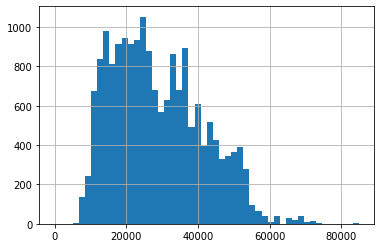

In [53]:
raw_df['airport_nearest'].hist(bins=50)

Как уже указывалось в замечаниях после первого ознакомления с данными, ценность данного параметра не ясна - критичными являются только два случая - слишким близко (самолеты низко летают и мешают гудением) и слишком далеко (долго добираться).  На гистограмме сразу видно, что основное распределение далее 10 км, а ближе 5 км статистически вообще нет.  Также можно сказать, что основное распределение ближе 55 км - это 2 часа на автомобиле в среднем.  Так что все распределение попадает в диапазон малой зависимости от данного параметра цены.  При исследовании подтвердим.

много отсутствующих значений - их можно попробовать заполнить средними для данного населенного пункта.  но сперва посмотрим много ли повторяющихся значений в исходном датасете:

In [54]:
raw_df['airport_nearest'].value_counts().head()

37434.0    61
21928.0    32
39946.0    30
44870.0    30
18732.0    27
Name: airport_nearest, dtype: int64

странная геолокация - даже если предположить, что округление до метра, неужели на расстоянии ровно 37434 метра от аэропорта в выборке их 18157 объектов нашлось аж 61 !?  Ну разве что новостройки продают!  Посмотрим еще немного на данный феномен: 

In [55]:
(raw_df['airport_nearest'].value_counts() > 5).sum() # сколько значений с аномальным числом совпадений

492

In [56]:
freq_dist_list = list( raw_df['airport_nearest'].value_counts().head(492).index ) # список аномально частых значений расстояния

raw_df.query('airport_nearest in @freq_dist_list')['locality_name'].value_counts() # глянем, где это чаще происходит

Санкт-Петербург    3920
Парголово           208
Шушары              162
Пушкин               49
Колпино              43
Сестрорецк           22
Красное Село         12
nan                  11
Петергоф              9
Ломоносов             6
Металлострой          5
Стрельна              3
Name: locality_name, dtype: int64

In [57]:
raw_df.query('airport_nearest in @freq_dist_list')['locality_name'].value_counts().sum() # и в каком количестве всего

4450

всего в десятке населенных пунктов, причем 88% приходятся на Питер

Удивительно - при этом полных дупликатов в строках нет изначально!  Может это несколько объявлений по одному объекту - к сожалению информации в таблице недостаточно для идентификации объекта - только для идентификации объявления.  Проверим по выделенно локации, например город Пушкин:

In [58]:
Pouchkine_anomaly_df = raw_df.query('(airport_nearest in @freq_dist_list) & (locality_name == "Пушкин")')
Pouchkine_anomaly_df['airport_nearest'].value_counts() # проверим на уникальность значений расстояний

18539.0    10
18079.0     9
19715.0     7
18271.0     6
14135.0     6
20562.0     3
16877.0     2
13520.0     2
20028.0     1
17101.0     1
14448.0     1
18490.0     1
Name: airport_nearest, dtype: int64

In [59]:
Pouchkine_anomaly_df.query('airport_nearest == 18079.0')[['floors_total', 'rooms']].value_counts()
# проверяем для произвольного значений с топа аномальных расстояний выше, косвенные параметры, позволяющие разделять объекты

floors_total  rooms
6.0           1        5
5.0           1        1
              2        1
6.0           3        1
7.0           2        1
dtype: int64

В данной таблице четко видно, что как минимум у трех разных домов (разная этажность) указано одинаковое расстояние до метра до аэропорта.  Это не похоже на картографию.  С другой стороны точность GPS позиционирования 10-50 метров, размеры самого дома тоже порядка 10х50, так что последняя цифра левее ноля вообще случайна (но это лишь увеличивает подозрения относитьно совпавших до метра цифр).  Скорее всего тот кто должен был вносить в объявления данные упрощал работу и мог брать уже внесенное расстояние из близких объектов. 

Попробуем заполнить отсутствующие данные - средним значением по населенному пункту.


Сперва подготовим таблицу средних значений расстояния до аэропорта по всем населенным пунктам - в виде словаря {населенный пункт : среднее по населенному пункту расстояние до аэропорта}:

In [60]:
locations_list = list(raw_df['locality_name'].value_counts().index) # упорядоченный список населенных пунктов - по убыванию числа записей

# задача получить словарь вида {населенный пункт : среднее по населенному пункту расстояние до аэропорта}
# Однако работу сильно осложняют NaN и отказ интерпретатора делать сравнения x == NaN.  
# Нас устроит замена NaN на 0.0, так как это значение также нерелевантно семантике параметра
# так как на уровне словаря операция fillna не поддерживается - делаем через промежуточный датафрейм

airport_dist_pairs_list = []
for string in locations_list:
    airport_dist_pairs_list.append([string, raw_df[raw_df['locality_name'] == string]['airport_nearest'].mean()]) 
    
airport_dist_pairs_df = pd.DataFrame(data=airport_dist_pairs_list, columns=('locality_name', 'avg_dist_airport'))
airport_dist_pairs_df['avg_dist_airport'] = airport_dist_pairs_df['avg_dist_airport'].fillna(0.0)

airport_dist_dict = {}
for i in airport_dist_pairs_df.index:
    airport_dist_dict[airport_dist_pairs_df.loc[i,'locality_name']] = airport_dist_pairs_df.loc[i,'avg_dist_airport']

dict_is_filled = 100 * ( airport_dist_pairs_df.query('avg_dist_airport != 0.0')['avg_dist_airport'].count() 
                        / airport_dist_pairs_df['avg_dist_airport'].count() )
print(f'только {round(dict_is_filled,1)}% населенных пунктов имеют статистику по расстоянию до аэропорта')

только 9.0% населенных пунктов имеют статистику по расстоянию до аэропорта


Но как мы помним, менее 10% населенных пунктов покрывают более 90% всех объявлений, поэтому будем надеятся, что они существенно перекрываются.  В любом случае осталось мало сделать, чтобы по возможности заполнить пробелы в информации о расстоянии до аэропорта:

теперь построчной функцией проводим замену значения только в тех записях, где расстояние до аэропорта равно нулю, но известен населенный пункт, по которому можно задействовать словарь подстановки 

In [61]:
raw_df['airport_nearest'] = raw_df['airport_nearest'].fillna(0.0) # убираем NaN, с которыми тяжело работать
raw_df['locality_name'] = raw_df['locality_name'].fillna('') # убираем NaN, с которыми тяжело работать

# теперь все NaN в столбце расстояний до аэропорта заменены на 0.0 - и в словаре и в дата фрейме
def airport_dist_insert(df):
    dist = df['airport_nearest']
    place = df['locality_name']
    
    if dist != 0.0: return dist
    elif place != '' : return airport_dist_dict[place]
    else: return 0.0 
    
raw_df['airport_nearest'] = raw_df.apply(airport_dist_insert, axis=1) 

raw_df['airport_nearest'].value_counts().head(6)

0.000000        4829
51553.000000     590
28046.186237      86
37434.000000      61
21928.000000      32
44870.000000      30
Name: airport_nearest, dtype: int64

определенный эффект есть - мы видим, что в пятерке лидеров (не считая нулевое расстояние) появились две новые позиции: (51553.000000, 590) и (28046.186237, 86), но в целом кол-во записей с ненулевым расстоянием до аэропорта не сильно поменялось:

до замены средними оно было 23699 - 18157 = 5542

после замены стало их стало 4829

улучшение в 713 записях из 5542, то есть только в 13% случаях отсутствия информации удалось подставить среднее значение.  Видимо, среди 92% населенных пунктов без статистики расстояний до аэропорта попадаются достаточно крупные, чтобы все еще 20.4% всех записей не имели данных о расстоянии до аэропорта

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = нет, 
* дополнительный бонус к цене = да, 
* нужность для задач проекта = слабая (при заполнении пробелов в параметрах расстояния и зеленой зоны) 

**Выводы:** данные по-прежнему неполные - информация отсутствует у 20.4% объявлений.  Тип соответствует семантике (float). Информация вставляется при регистрации объявления по картографическим данным.

**Замечено:** отсутствующие данные относятся к целым населенным пунктам, по которым их нет (всего таких населенных пунктов 283 и несмотря на техническую возможность найти такую информацию в яндекс картах - это банально долго, и как уже говорилось, польза от данного параметра не ясна.

Дальнейшая предобработка нецелесообразна.  Возможна замена данного столбца на минус 1 балл к зеленой зоне, если, скажем расстояние до аэропорта менее 5 км.

#### `16.  city_center_nearest` - расстояние до центра города (м)

сразу разобьем статистику на Питер и окрестности:

In [62]:
st_piter_dist_stat = raw_df.query('locality_name == "Санкт-Петербург"')['city_center_nearest'].describe()

province_dist_stat = raw_df.query('~(locality_name in ["Санкт-Петербург", "nan"])')['city_center_nearest'].describe()
# после удаления скрытых дупликатом в именах населенных пунктов NaN превратилось в 'nan'

dist_stat_df = pd.DataFrame(
    {
        'Столица' : st_piter_dist_stat,
        'Область' : province_dist_stat
    }
)

display(dist_stat_df)

,Столица,Область
count,15660.000000,2479.000000
mean,11601.291571,30600.552642
std,4842.035279,9071.837149
min,181.000000,17012.000000
25%,8327.000000,24740.000000
50%,12244.500000,30371.000000
75%,14943.000000,33719.000000
max,29493.000000,65968.000000


В таком представлении отлично видно, что данные являются расстоянием до центра Питера - даже если населенный пункт в регионе: минимальное расстояние в колонке "Область выше" 17 км, тогда как 75% значений в колонке "Столица" приходятся на радиус в 15 км.  Из чисто эстетических соображений полюбуемся на это и на графике: 

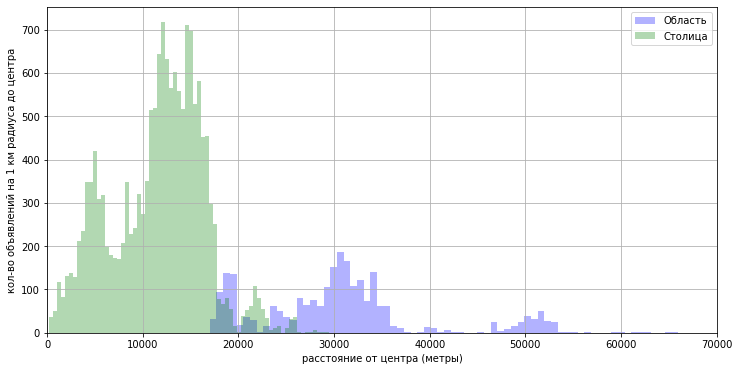

In [63]:
import matplotlib.pyplot as plt

common_ax = raw_df.query('~(locality_name in ["Санкт-Петербург", "nan"])')['city_center_nearest'].plot(
    xlim=(0,70000), figsize=(12,6),
    kind='hist', bins=70, 
    color='blue', alpha=0.3, label='Область'    
)

raw_df.query('(locality_name == "Санкт-Петербург")')['city_center_nearest'].plot(
    ax=common_ax, sharex=True, sharey=True, 
    kind='hist',bins=70, 
    color='green', alpha=0.3, label='Столица'
)

plt.xlabel('расстояние от центра (метры)')
plt.ylabel('кол-во объявлений на 1 км радиуса до центра')
plt.legend()
plt.grid()

график позволяет визуально категоризовать объевления по расстоянию на четкие группы:
* `центр           -` 0-7 км (центральное кольцо города)
* `спальные районы -` 7-17 км
* `окраина         -` 17-30 км (но уже Питер)
* `за кольцевой    -` 17-26 км (еще область, куда дорос город по внешней границе - в случае Москвы подошло бы "замкадье")
* `пригород        -` 26-37 км
* `область         -` 37-66 км (отдельные пики определены просто географическим разбросом населенных пунктов по карте)

(при трактовке графика также следует понимать, что реальная плотность объектов на квадратный километр можно получить, поделив значения столбца $Y$ на ${2 \pi Х \over 1000}$, так как сейчас на графике кол-во объявлений в кольцевом сегменте 1 км по радиусу и $2 \pi R$ длины окружности с радиусом $X$)

Данный столбец дает отличный параметр цены и естественным образом категоризируется, но в нем много отсутствующей информации - в 23.3% всех объявлений данный параметр не указан.   Посмотрим полноту данных отдельно по Питеру и по Области - область можно заполнить средним по населенному пункту, а вот Питер: замешивать цены в центре, в спальном районе и на окраине в столичном городе - плохая идея!

In [64]:
raw_df.query('locality_name == "Санкт-Петербург"')['city_center_nearest'].isna().mean()

0.003880160295146619

Ну хоть тут повезло: только 0,38% объявлений по Питеру не имеют информации о расстоянии до центра!  **Выбросим их, чтобы не смазывать сегментацию цен!**

а с областью попробуем заполнить нули, как это делали по столбцу для расстояния до аэропорта - хочется надеятся, что результат будет лучше, так как, в отличие от расстояния до аэропорта, параметр расстояния до центра ожидается гораздо более влиятельным на цену. 

In [65]:
# список location_list у нас сохранился как объект, нулевым элементом идет Питер, остальные нас.пункты в срезе [1:]

center_dist_pairs_list = []
for string in locations_list[1:]:
    center_dist_pairs_list.append([string, raw_df[raw_df['locality_name'] == string]['city_center_nearest'].mean()]) 
    
center_dist_pairs_df = pd.DataFrame(data=center_dist_pairs_list, columns=('locality_name', 'avg_dist_center'))
center_dist_pairs_df['avg_dist_center'] = center_dist_pairs_df['avg_dist_center'].fillna(0.0)

center_dist_dict = {}
for i in center_dist_pairs_df.index:
    center_dist_dict[center_dist_pairs_df.loc[i,'locality_name']] = center_dist_pairs_df.loc[i,'avg_dist_center']

dict_is_filled = 100 * ( center_dist_pairs_df.query('avg_dist_center != 0.0')['avg_dist_center'].count() 
                        / center_dist_pairs_df['avg_dist_center'].count() )
print(f'{round(dict_is_filled,1)}% областных пунктов имеют статистику по расстоянию до центра Питера')

8.7% областных пунктов имеют статистику по расстоянию до центра Питера


**увы, ситуация столь же плоха, как было для пробелов в расстоянии до аэропорта**, однако параметр представляется центровым для сегментации цен - **придется заполнить его вручную по Яндекс-картам** (284 раза померять линейкой :( - это при эмпирически определенной средней скорости два заполненных пробела в минуту составит 2ч20 мин!) делаем:
выводим весь словарь, копипастим в команду присваивания и редактируем вручную нулевые расстояния

In [66]:
print(center_dist_dict)

{'Мурино': 21888.0, 'Кудрово': 0.0, 'Шушары': 24243.3876146789, 'Всеволожск': 0.0, 'Пушкин': 28745.375, 'Колпино': 32113.771513353116, 'Парголово': 19924.776758409786, 'Гатчина': 0.0, 'Выборг': 0.0, 'Петергоф': 35468.92537313433, 'Сестрорецк': 34624.48087431694, 'Красное Село': 30020.284090909092, 'Новое Девяткино': 0.0, 'Сертолово': 0.0, 'Ломоносов': 50739.969696969696, 'Кириши': 0.0, 'Бугры': 0.0, 'Сланцы': 0.0, 'Волхов': 0.0, 'Кингисепп': 0.0, 'Тосно': 0.0, 'Кронштадт': 49195.72631578947, 'Никольское': 0.0, 'Коммунар': 0.0, 'Сосновый Бор': 0.0, 'Кировск': 0.0, 'Отрадное': 0.0, 'Янино-1': 0.0, 'Металлострой': 27561.348484848484, 'Приозерск': 0.0, 'Старая': 0.0, 'Шлиссельбург': 0.0, 'Луга': 0.0, 'Тихвин': 0.0, 'nan': 11278.90243902439, 'Стрельна': 23376.113636363636, 'Тельмана': 0.0, 'Рощино': 0.0, 'Павловск': 33206.92105263158, 'Волосово': 0.0, 'Романовка': 0.0, 'имени Свердлова': 0.0, 'Кузьмоловский': 0.0, 'Мга': 0.0, 'Сиверский': 0.0, 'Ивангород': 0.0, 'Новоселье': 0.0, 'Сясьстрой'

In [67]:
center_dist_dict = {
    'Мурино': 21888.0, 
    'Кудрово': 12000.0, 
    'Шушары': 24243.3876146789, 
    'Всеволожск': 21500.0, 
    'Пушкин': 28745.375, 
    'Колпино': 32113.771513353116, 
    'Парголово': 19924.776758409786, 
    'Гатчина': 42500.0, 
    'Выборг': 122000.0, 
    'Петергоф': 35468.92537313433, 
    'Сестрорецк': 34624.48087431694, 
    'Красное Село': 30020.284090909092, 
    'Новое Девяткино': 16300.0, 
    'Сертолово': 23500.0, 
    'Ломоносов': 50739.969696969696, 
    'Кириши': 110000.0, 
    'Бугры': 15300.0, 
    'Сланцы': 156000.0, 
    'Волхов': 115000.0, 
    'Кингисепп': 115000.0, 
    'Тосно': 54500.0, 
    'Кронштадт': 49195.72631578947, 
    'Никольское': 37500.0, 
    'Коммунар': 35500.0, 
    'Сосновый Бор': 68000.0, 
    'Кировск': 38500.0, 
    'Отрадное': 33000.0, 
    'Янино-1': 14000.0, 
    'Металлострой': 27561.348484848484, 
    'Приозерск': 123000.0, 
    'Старая': 18000.0, 
    'Шлиссельбург': 41000.0, 
    'Луга': 151000.0, 
    'nan': 0.0, # эти строки будут удалены в конце преобработки 
    'Тихвин': 184000.0, 
    'Стрельна': 23376.113636363636, 
    'Тельмана': 29000.0, 
    'Рощино': 52500.0, 
    'Павловск': 33206.92105263158, 
    'имени Свердлова': 24000.0, 
    'Волосово': 72000.0, 
    'Романовка': 25000.0, 
    'Кузьмоловский': 21000.0, 
    'Мга': 47000.0, 
    'Сиверский': 66000.0, 
    'Ивангород': 133000.0, 
    'Новоселье': 19000.0, 
    'Щеглово': 34085.0, 
    'Зеленогорск': 54617.583333333336, 
    'Сясьстрой': 128000.0, 
    'Вырица': 58000.0, 
    'Новый Свет': 42500.0, 
    'Синявино': 43000.0, 
    'Лодейное Поле': 200000.0, 
    'Новогорелово': 18000.0, 
    'Понтонный': 32293.45, 
    'Токсово': 26500.0, 
    'Вартемяги': 27000.0, 
    'Лесколово': 38500.0, 
    'Подпорожье': 239000.0, 
    'Пикалёво': 222000.0, 
    'Сосново': 69000.0, 
    'Павлово': 35000.0, 
    'Бегуницы': 68500.0, 
    'Большая Ижора': 41000.0, 
    'Назия': 57500.0, 
    'Гарболово': 46000.0, 
    'имени Морозова': 41000.0, 
    'Бокситогорск': 207000.0, 
    'Большие Колпаны': 48500.0, 
    'Аннино': 23500.0, 
    'Лебяжье': 50000.0, 
    'Дубровка': 36500.0, 
    'Фёдоровское': 33000.0, 
    'Горбунки': 23000.0, 
    'Рахья': 34000.0, 
    'Новая Ладога': 114000.0, 
    'Ульяновка': 42000.0, 
    'Каменногорск': 131000.0, 
    'Елизаветино': 57000.0, 
    'Кузнечное': 134000.0, 
    'Гостилицы': 43500.0, 
    'Малое Верево': 37000.0, 
    'Колтуши': 19500.0, 
    'Советский': 112000.0, 
    'Белогорка': 66000.0, 
    'Нурма': 58000.0, 
    'Светогорск': 153000.0, 
    'Мичуринское': 74000.0, 
    'Мистолово': 21000.0, 
    'Любань': 85000.0, 
    'Лаголово': 30000.0, 
    'Низино': 27000.0, 
    'Войсковицы': 49000.0, 
    'Сяськелево': 50000.0, 
    'Сельцо': 55500.0, 
    'Батово': 72500.0, 
    'Малое Карлино': 23700.0, 
    'Русско-Высоцкое': 33800.0, 
    'Приладожский': 57500.0, 
    'Оржицы': 39000.0, 
    'Молодцово': 46000.0, 
    'Кобралово': 39500.0, 
    'Пудость': 38500.0, 
    'Красный Бор': 35000.0, 
    'Приморск': 106000.0, 
    'Запорожское': 72000.0, 
    'Суходолье': 88000.0, 
    'Ильичёво': 48000.0, 
    'Первомайское': 56500.0, 
    'Калитино': 70000.0, 
    'Стеклянный': 50000.0, 
    'Малые Колпаны': 45500.0, 
    'Куттузи': 24500.0, 
    'Кальтино': 20500.0, 
    'Никольский': 234000.0, 
    'Извара': 79000.0, 
    'Кузьмолово': 23300.0, 
    'Кипень': 38000.0, 
    'Углово': 28000.0, 
    'Важины': 235000.0, 
    'Новый Учхоз': 48500.0, 
    'Лопухинка': 55000.0, 
    'Лампово': 73000.0, 
    'Сапёрный': 35854.666666666664, 
    'Пудомяги': 37000.0, 
    'Терволово': 37500.0, 
    'Яльгелево': 31000.0, 
    'Тайцы': 32000.0, 
    'Ушаки': 65000.0, 
    'Поляны': 73000.0, 
    'Форносово': 43500.0, 
    'Заневка': 12000.0, 
    'Пеники': 37000.0, 
    'Кобринское': 58000.0, 
    'Победа': 67000.0, 
    'Плодовое': 101000.0, 
    'Копорье': 76000.0, 
    'Дружная Горка': 73500.0, 
    'Семрино': 44000.0, 
    'Мельниково': 115000.0, 
    'Петровское': 78000.0, 
    'Усть-Луга': 118000.0, 
    'Лесогорский': 150000.0, 
    'Селезнёво': 131000.0, 
    'Молодёжное': 65529.2, 
    'Глажево': 107000.0, 
    'Гаврилово': 101000.0, 
    'Войскорово': 31000.0, 
    'Юкки': 20000.0, 
    'Рябово': 74500.0, 
    'Кикерино': 65500.0, 
    'Большая Вруда': 84000.0, 
    'Старая Малукса': 68500.0, 
    'Репино': 43392.25, 
    'Песочный': 26475.25, 
    'Разбегаево': 26500.0, 
    'Торфяное': 44000.0, 
    'Разметелево': 21000.0, 
    'Высоцк': 123000.0, 
    'Будогощь': 141000.0, 
    'станции Вещево': 103000.0, 
    'Зимитицы': 79500.0, 
    'Суйда': 53000.0, 
    'Келози': 40500.0, 
    'Парицы': 47000.0, 
    'Агалатово': 31500.0, 
    'Цвелодубово': 65000.0, 
    'Перово': 112000.0, 
    'Пригородный': 45000.0, 
    'Аро': 19500.0, 
    'Виллози': 29000.0, 
    'Красная Долина': 87000.0, 
    'Рождествено': 71500.0, 
    'станции Громово': 88000.0, 
    'Жилгородок': 26300.0, 
    'Ваганово': 43300.0, 
    'Лисий Нос': 27613.333333333332, 
    'Торосово': 62500.0, 
    'Лесное': 49500.0, 
    'Старосиверская': 64500.0, 
    'Торошковичи': 153000.0, 
    'Громово': 85000.0, 
    'Заводской': 43000.0, 
    'Лукаши': 38500.0, 
    'Ефимовский': 250000.0, 
    'Котельский': 95500.0, 
    'Глебычево': 105000.0, 
    'Рабитицы': 78500.0, 
    'Возрождение': 127000.0, 
    'Оредеж': 124000.0, 
    'Старополье': 139000.0, 
    'Заклинье': 137000.0, 
    'Торковичи': 120000.0, 
    'Коробицыно': 72500.0, 
    'Серебрянский': 156000.0, 
    'Фалилеево': 89500.0, 
    'Вознесенье': 309000.0, 
    'Камышовка': 88500.0, 
    'Суоранда': 17000.0, 
    'Усть-Ижора': 28222.5, 
    'Пушное': 70000.0, 
    'станции Свирь': 237000.0, 
    'Коркино': 23000.0, 
    'Пансионат Зелёный Бор': 141000.0, 
    'Мины': 57500.0, 
    'Ям-Тесово': 117000.0, 
    'Ленинское': 41000.0, 
    'Сумино': 69500.0, 
    'Старая Ладога': 111000.0, 
    'Александровская': 27468.0, 
    'Паша': 159000.0, 
    'Совхозный': 229000.0, 
    'Житково': 100000.0, 
    'Сапёрное': 88500.0, 
    'Путилово': 64000.0, 
    'Ненимяки': 46000.0, 
    'Старая Пустошь': 21500.0, 
    'Починок': 116000.0, 
    'станции Приветнинское': 56000.0, 
    'Бор': 21000.0, 
    'Барышево': 93500.0, 
    'Выскатка': 158000.0, 
    'Кингисеппский': 115000.0, 
    'Старые Бегуницы': 67500.0, 
    'Тарасово': 67500.0, 
    'Глинка': 30500.0, 
    'Жилпосёлок': 56000.0, 
    'Курковицы': 67000.0, 
    'Шпаньково': 55500.0, 
    'Вахнова Кара': 166000.0, 
    'Пижма': 49000.0, 
    'Чудской Бор': 90500.0, 
    'садовое товарищество Рахья': 34500.0, 
    'Терпилицы': 73000.0, 
    'Коммунары': 109000.0, 
    'Большой Сабск': 115000.0, 
    'Тойворово': 48500.0, 
    'Высокоключевой': 53000.0, 
    'Пикколово': 28000.0, 
    'Пчевжа': 132000.0, 
    'Кирпичное': 79000.0, 
    'Старое Хинколово': 56500.0, 
    'Снегирёвка': 68500.0, 
    'Плоское': 126000.0, 
    'Борисова Грива': 40800.0, 
    'Форт Красная Горка': 54500.0, 
    'садовое товарищество Приладожский': 57500.0, 
    'Хапо-Ое': 25200.0, 
    'Свирьстрой': 212000.0, 
    'Рапполово': 26000.0, 
    'Русско': 147000.0, 
    'Дзержинского': 144000.0, 
    'садовое товарищество Новая Ропша': 32000.0, 
    'Красносельское': 81000.0, 
    'Цвылёво': 166000.0, 
    'Шугозеро': 218000.0, 
    'Хязельки': 21000.0, 
    'Платформа 69-й километр': 64000.0, 
    'Куровицы': 61500.0, 
    'Володарское': 160000.0, 
    'садоводческое некоммерческое товарищество Лесная Поляна': 60000.0, 
    'Счастье': 32000.0, 
    'Гладкое': 45000.0, 
    'Сижно': 152000.0, 
    'Шум': 83000.0, 
    'Тёсово-4': 128000.0, 
    'Почап': 126000.0, 
    'Меньково': 59000.0, 
    'Левашово': 25727.0, 
    'Нижняя': 31000.0, 
    'Малая Романовка': 26000.0, 
    'Ромашки': 91500.0, 
    'Новолисино': 49000.0, 
    'Гончарово': 114000.0, 
    'при железнодорожной станции Приветнинское': 55000.0, 
    'Пельгора': 76000.0, 
    'Лупполово': 24000.0, 
    'Реброво': 128000.0, 
    'Дружноселье': 70000.0, 
    'Кивеннапа Север': 55000.0, 
    'Большая Пустомержа': 101000.0, 
    'Каськово': 57500.0, 
    'Иссад': 115000.0, 
    'Котлы': 95000.0, 
    'Алексеевка': 103000.0, 
    'Белоостров': 38868.0, 
    'Петро-Славянка': 27165.0, 
    'Тихковицы': 60500.0, 
    'Кондратьево': 142000.0, 
    'Трубников Бор': 96500.0, 
    'станции Корнево': 28000.0, 
    'Лаврики': 17200.0, 
    'садовое товарищество Садко': 80500.0, 
    'Раздолье': 71500.0, 
    'Ропша': 34000.0, 
    'Каложицы': 93500.0, 
    'Мануйлово': 103000.0, 
    'Нижние Осельки': 32500.0, 
    'Кисельня': 103000.0, 
    'Кривко': 72500.0, 
    'Пустынка': 42000.0, 
    'Мыза-Ивановка': 39000.0, 
    'Пчева': 110000.0, 
    'Большое Рейзино': 40500.0, 
    'Семиозерье': 70500.0, 
    'станции Лужайка': 140000.0, 
    'при железнодорожной станции Вещево': 103000.0, 
    'Ялгино': 173000.0, 
    'Севастьяново': 128000.0}

In [68]:
cc = 0  # этот код показывал мне свет в конце тоннеля - оставил его как пямятник бессонной ночи в Яндекс-картах!
for i in center_dist_dict: 
    if center_dist_dict[i] == 0.0: cc += 1
print(f'тебе осталось {cc}, последний рывок!')

тебе осталось 1, последний рывок!


оставшееся одно нулевое значение соответствует locality_name == 'nan', ставшему строкой после удаления скрытых дупликатов - эти строки потом удалятся в конце предобработки.  Осталось воспользоваться введенной информацией о расстоянии населенных пунктов до центра Питера и заполнить пробелы в данном столбце:

In [69]:
raw_df['city_center_nearest'] = raw_df['city_center_nearest'].fillna(0.0) # убираем NaN, с которыми тяжело работать

def center_dist_insert(df):
    dist = df['city_center_nearest']
    place = df['locality_name']
    
    if place == 'Санкт-Петербург': return dist
    if dist != 0.0: return dist
    elif place != 'nan' : return center_dist_dict[place]
    else: return 0.0 
    
raw_df['city_center_nearest'] = raw_df.apply(center_dist_insert, axis=1) 

(raw_df['city_center_nearest'] == 0.0).sum() # проверим сколько осталось нулей

69

оставшиеся 69 записей (0.3%) с 0.0 относятся к Питеру и будут удалены при удалении записей в завершении предобработки далее.  Посмотрим как поменялись наши распределения объявлений по расстоянию для столицы и области:

In [70]:
st_piter_dist_stat = raw_df.query('locality_name == "Санкт-Петербург"')['city_center_nearest'].describe()

province_dist_stat = raw_df.query('~(locality_name in ["Санкт-Петербург", "nan"])')['city_center_nearest'].describe()
# после удаления скрытых дупликатом в именах населенных пунктов NaN превратилось в 'nan'

dist_stat_df = pd.DataFrame(
    {
        'Столица' : st_piter_dist_stat,
        'Область' : province_dist_stat
    }
)

display(dist_stat_df)

,Столица,Область
count,15721.000000,7929.000000
mean,11556.276700,47313.176688
std,4886.160631,41680.039059
min,0.000000,12000.000000
25%,8294.000000,21888.000000
50%,12219.000000,31500.000000
75%,14938.000000,51100.000000
max,29493.000000,309000.000000


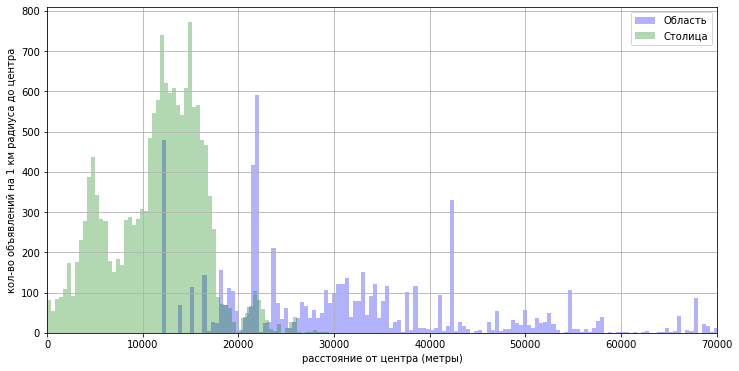

In [71]:
common_ax = raw_df.query('~(locality_name in ["Санкт-Петербург", "nan"])')['city_center_nearest'].plot(
    xlim=(0,70000), figsize=(12,6),
    kind='hist', bins=700, # стараемся выдержать тот же километраж на 1 bin для обеих гистограмм
    color='blue', alpha=0.3, label='Область'    
)

raw_df.query('(locality_name == "Санкт-Петербург")')['city_center_nearest'].plot(
    ax=common_ax, sharex=True, sharey=True, 
    kind='hist',bins=70, 
    color='green', alpha=0.3, label='Столица'
)

plt.xlabel('расстояние от центра (метры)')
plt.ylabel('кол-во объявлений на 1 км радиуса до центра')
plt.legend()
plt.grid()

внесем правки в идею визуально категоризовать объевления по расстоянию на четкие группы:
* `центр           -` 0-7 км (центральное кольцо города)
* `спальные районы -` 7-17 км (Питер)
* `окраина         -` > 17 км (Питер)
* `за кольцевой    -` < 26 км (Область, куда дорос город по внешней границе - в случае Москвы подошло бы "замкадье")
* `пригород        -` 26-37 км
* `ближняя область -` 37-100 км (отдельные пики определены просто географическим разбросом населенных пунктов по карте)
* `дальняя область -` > 100 км (отдельные пики определены просто географическим разбросом населенных пунктов по карте)

обратим внимание, что по факту категоризация идет по двум параметрам - расстояние и столица/область, которые сводятся в одну категорию!

после предобработки и перед категоризацией еще сравним эту идею категоризации с графиком цены квадратного метра от расстояния

**Роль:**
ценовой сегмент = да (после категоризации),
расчет средних цен = нет,
тип объекта = нет,
дополнительный бонус к цене = нет,
нужность для задач проекта = максимальная.

**Выводы:** значения после заполнения присутствуют во всех записях. Тип данных (float64) соответствует семантике. Источник информации - сотрудник, регистрирующий объявление

**Замечено:** параметр и его статистика позволяют естественную категоризацию на 7 категорий (см. выше) - подлежит проверке при анализе зависимости цены от расстояния

Дальнейшая предобработка не нужна

#### `17. parks_around3000` - число парков в радиусе 3 км `| 19. ponds_around3000` - число водоёмов в радиусе 3 км
есть идея объединить данные параметры в одну категорию `green_mile`, для которой и заполнять потом пробелы.  Возможно добавить потом к этой же категории близость к аэропорту.

Изучим их статистику:

In [72]:
raw_df['parks_around3000'].value_counts()

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

In [73]:
raw_df['ponds_around3000'].value_counts()

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

поскольку кол-ва ненулевых значений совпадают, есть искушение проверить не совпадают ли они по одинаковым записям - может упростить категоризацию.

In [74]:
raw_df[~(raw_df['parks_around3000'].isna())]['ponds_around3000'].isna().mean()

0.0

**Роль:**
* ценовой сегмент = нет,
* расчет средних цен = нет,
* тип объекта = нет,
* дополнительный бонус к цене = да,
* нужность для задач проекта = слабая 

**Вывод:** Многие данные отсутствуют, но поскольку возможная ценность данных столбцов только в определении поправки к цене в сегменте, то необходимости в их заполнении нет.
Данные столбцы при анализе будут заменены на общую категорию green_mile (зеленая зона) - поэтому заполнение пробелов будет осуществлятьс уже в столбце категории по необходимости.  Данные разумные.

**Замечено:** данные в паре столбцов присутствуют строго одновременно, что позволяет просто ввести категорию как сумму значений и поменять все большие Х на Х

Предобработка не нужна

#### `18. park_nearest` - расстояние до ближайшего парка (м) `| 20. pond_nearest` - расстояние до ближайшего водоёма (м)
также есть идея объединить в одну категорию, отражающую близость места для выгула собак/колясок и/или спорта/пикника

In [75]:
raw_df[['park_nearest','pond_nearest']].describe() # с value_conts() такой трюк не прошел - там считает уникальные сочетания

,park_nearest,pond_nearest
count,8079.000000,9110.000000
mean,490.804555,517.980900
std,342.317995,277.720643
min,1.000000,13.000000
25%,288.000000,294.000000
50%,455.000000,502.000000
75%,612.000000,729.000000
max,3190.000000,1344.000000


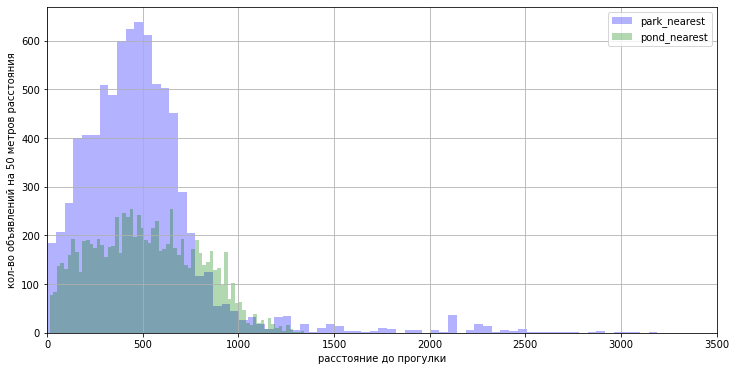

In [76]:
common_aax = raw_df['park_nearest'].plot(
    xlim=(0,3500), figsize=(12,6),
    kind='hist', bins=70, 
    color='blue', alpha=0.3    
)

raw_df['pond_nearest'].plot(
    ax=common_aax, sharex=True, sharey=True, 
    kind='hist',bins=70, 
    color='green', alpha=0.3
)

plt.xlabel('расстояние до прогулки')
plt.ylabel('кол-во объявлений на 50 метров расстояния')
plt.legend()
plt.grid()

опять видна идея категоризации:
* `рядом      - ` менее 500 метров
* `доступно   -` от 500 до 1000 метров
* `далеко     -` свыше 1000 метров
* `не указано -` отсутствие информации в объявлении нам подходит, так как мы по факту анализируем рыночную стоимость объявления

**Роль:** 
* ценовой сегмент = нет, 
* расчет средних цен = нет, 
* тип объекта = нет, 
* дополнительный бонус к цене = да, 
* нужность для задач проекта = слабая  

**Вывод:**  Многие данные отсутствуют, но поскольку возможная ценность данных столбцов только в определении поправки к цене в сегменте, то необходимости в их заполнении нет.  Тип данных устраивает - все равно оба столбца будут заменены на одну категорию для анализа.  Источник информации - сотрудник, регистрирующий заявку.

**Замечено:** в отличие от пары по зеленой зоне, данная пара присутствует синхронно только в 70% ненулевых значений

Дальнейшая предобработка не нужна

#### `21. days_exposition` - сколько дней было размещено объявление (от публикации до снятия)

last but not the least!
Это очень полезный параметр, косвенно указывающий на адекватность цены объявления - рыночной (цене).  Он не входит в сегментацию цены, но он может быть использован в "хитрых" правилах вычисления средних цен по сегменту - можно выдумывать различные функции достоверности цены объявления в зависимости от него и от даты размещения, и вводить собственные весы усреднения вместо mean() и median(). 

Но пока ограничимся предобработкой столбца:

In [77]:
raw_df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

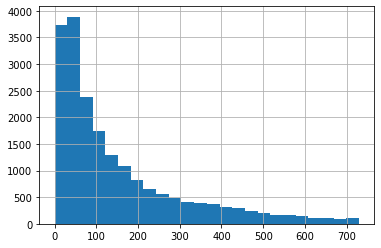

In [78]:
raw_df['days_exposition'].hist(bins=2*12, range=(0,2*365)) # один bin составит примерно один месяц

график ожидаемо напоминает экспоненту по типу вероятности радиоактивного распада - период "полураспада" (продажи половины квартир) = 95 дней, в первый месяц продается порядка 3700/20500 = 18%.

Это среднее по всей статистике, в сегментах будет другое.  Поскольку мы трактуем данный столбец как вероятность продажи, то отсутствующие значения целесообразно заменять средними - желательно по сегменту, так как скорости продаж однушек и трешек, например, различаются.  Поскольку сегментация еще не проведена пока оставим этот столбец как есть - его сперва нужно использовать при определении даты актуальности цены

### Завершение предобработки данных

посмотрим в каких столбцах данные еще отсутствуют

In [79]:
raw_df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
is_studio                   0
is_open_plan                0
kitchen_area             2278
balconies                   0
locality_name               0
airport_nearest             0
city_center_nearest         0
parks_around3000         5518
park_nearest            15620
ponds_around3000         5518
pond_nearest            14589
days_exposition          3181
dtype: int64

* `ceiling_height (9195)   -` много отсутствующих данных, посмотрим в предварительном анализе, можно ли восстановить по типу объекта
* `floors_total (86)       -` эти записи будут удалены
* `living_area (1903)      -` бонус к цене, посмотрим в предварительном анализе, можно ли восстановить по типу объекта
* `is_apartment (20924)    -` не удалось понять семантику, данные практически пустые - данный столбец удалим
* `kitchen_area (2278)     -` бонус к цене, посмотрим в предварительном анализе, можно ли восстановить по типу объекта
* `parks_around3000 (5518) -` в категорию зеленая зона
* `park_nearest (15620)    -` в категорию зона прогулок
* `ponds_around3000 (5518) -` в категорию зеленая зона
* `pond_nearest (14589)    -` в категорию зона прогулок
* `days_exposition (3181)  -` отсутствие данных здесь можно рассматривать как то, что объявление валидно на последний день, так что их удалять не надо!

кроме того у нас еще есть значения 0.0 вместо отсутствующих значений в:
* `airport_nearest (4829)  -` в категорию зеленая зона
* `city_center_nearest (69)-` эти записи будут удалены

и значение 'nan' вместо отсутствующих значений в:

* `locality_name (49)      -` эти записи будут удалены 

**Резюме:** в результате детального анализа столбцов было принято решение об удалении записей со следующими признаками:

* `rooms not in (1,2,3,4,5)                        -` 0.1% от всех записей
* `(ceiling_height < 2.0) | (ceiling_height > 4.0) -` 0.5% от ненулевых записей в данном столбце
* `floors_total in (NaN, 1, 28+)                   -` 0.6% от всех записей
* `locality_name == 'nan'                          -` 0.2% от всех записей
* `city_center_nearest == 0.0                      -` 0.3% по всех записей

In [80]:
data_df = raw_df # пора переименовать наш датафрейм

data_df = data_df.query('rooms in (1,2,3,4,5)')
data_df = data_df.query('1 < floors_total < 28') 
data_df = data_df.query('locality_name != "nan"')
data_df = data_df.query('city_center_nearest != 0.0')

# с высотой потолков сложнее - там записи с NaN также будут выбрасываться, поэтому поступим в два этапа замены NaN:
data_df['ceiling_height'] = data_df['ceiling_height'].fillna(1000.0)
data_df = data_df.query('ceiling_height >= 2.0')
data_df['ceiling_height'] = data_df['ceiling_height'].replace(1000.0, 0.0) # перебрасываем наши NaN-ы на левый фланг
data_df = data_df.query('ceiling_height <= 4.0') # все записи с исходными NaN уцелели, топерь вместо NaN значение 0.0


теперь можно поправить типы и закончить предобработку обновлением индексов:

In [81]:
data_df['floors_total'] = data_df['floors_total'].astype('int')

data_df = data_df.reset_index(drop=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23319 entries, 0 to 23318
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23319 non-null  int64         
 1   last_price            23319 non-null  float64       
 2   total_area            23319 non-null  float64       
 3   first_day_exposition  23319 non-null  datetime64[ns]
 4   rooms                 23319 non-null  int64         
 5   ceiling_height        23319 non-null  float64       
 6   floors_total          23319 non-null  int32         
 7   living_area           21483 non-null  float64       
 8   floor                 23319 non-null  int64         
 9   is_apartment          2725 non-null   object        
 10  is_studio             23319 non-null  bool          
 11  is_open_plan          23319 non-null  bool          
 12  kitchen_area          21139 non-null  float64       
 13  balconies       

**Предобработка данных закончена, потери записей (23699 - 23319) / 23699 = 1.6\% от начального датасета**

## Первичный анализ и категоризация

### Разделяем столицу и область

поскольку далее и везде нам придется отдельно смотреть цену в Питере и в области, введем категорию для упрощения записи условий и вывода графиков:

In [82]:
data_df['is_piter'] = data_df['locality_name'] == 'Санкт-Петербург'

### Цена квадратного метра, дата актуальности цены и приведенная по дате цена

первым делом введем два ключевых параметра записей:
* стоимость квадратного метра - просто делим цену на общую площадь
* дата актуальности цены - тут сложнее:
 * это либо дата публикации + время экспозиции
 * если время экспозиции отсутствует, то это максимальная дата из всех возможных выше, она же актуальная дата для датасета (может быть позднее, чем 03-мая-2019

In [83]:
data_df['price_sq_meter'] = data_df['last_price'] / data_df['total_area'] # пользуемся алгеброй столбцов Пандас 

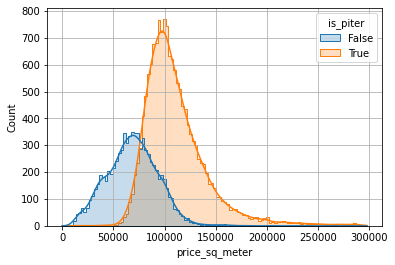

In [84]:
import seaborn as sns

sns.histplot(x='price_sq_meter', data=data_df[data_df['price_sq_meter']<300000], hue='is_piter', 
             element='step', kde = True)
plt.grid()

чтобы анализу не мешали выбросы значений (для защиты от сумасшедших авторов объвлений) обрежем цены, выбросив по области записи свыше 200 т.р., а в Питере - свыше 300 т.р.:

In [85]:
data_df = data_df.query('(is_piter & price_sq_meter < 300000) | ((~is_piter) & price_sq_meter < 200000)')
data_df = data_df.reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23152 entries, 0 to 23151
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23152 non-null  int64         
 1   last_price            23152 non-null  float64       
 2   total_area            23152 non-null  float64       
 3   first_day_exposition  23152 non-null  datetime64[ns]
 4   rooms                 23152 non-null  int64         
 5   ceiling_height        23152 non-null  float64       
 6   floors_total          23152 non-null  int32         
 7   living_area           21343 non-null  float64       
 8   floor                 23152 non-null  int64         
 9   is_apartment          2697 non-null   object        
 10  is_studio             23152 non-null  bool          
 11  is_open_plan          23152 non-null  bool          
 12  kitchen_area          21000 non-null  float64       
 13  balconies       

мы потеряли еще 0,7% от исходного датасета, но улучшили точность усреднений

теперь переходим к дате актуальности цены

In [86]:
from pandas.tseries.offsets import DateOffset

def date_of_price_linefunc(df):
    publish_dt = df['first_day_exposition']
    waiting_days = df['days_exposition']
    
    if waiting_days > 0.0:  # о! я экспериментально понял как обходить NaN в подстрочных функциях не заменяя их!
        price_date_dt = publish_dt + DateOffset(days=int(waiting_days))
        return price_date_dt
    else: return waiting_days # если NaN то он и вернется, так как переменные лишь указатели на объекты данных!

data_df['date_of_price'] = data_df.apply(date_of_price_linefunc, axis=1)

In [87]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23152 entries, 0 to 23151
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23152 non-null  int64         
 1   last_price            23152 non-null  float64       
 2   total_area            23152 non-null  float64       
 3   first_day_exposition  23152 non-null  datetime64[ns]
 4   rooms                 23152 non-null  int64         
 5   ceiling_height        23152 non-null  float64       
 6   floors_total          23152 non-null  int32         
 7   living_area           21343 non-null  float64       
 8   floor                 23152 non-null  int64         
 9   is_apartment          2697 non-null   object        
 10  is_studio             23152 non-null  bool          
 11  is_open_plan          23152 non-null  bool          
 12  kitchen_area          21000 non-null  float64       
 13  balconies       

теперь заменим NaN в date_of_price максимальным значением даты перед заменой - то есть мы предполагаем, что если записи о сроке экспозиции нет, то объявление все еще актуально (и цена):

In [88]:
data_df[['first_day_exposition','date_of_price']].describe(datetime_is_numeric=True)

,first_day_exposition,date_of_price
count,23152,20091
mean,2017-11-10 17:27:39.433310208,2018-03-21 06:45:06.047483904
min,2014-11-27 00:00:00,2016-06-16 00:00:00
25%,2017-05-16 00:00:00,2017-10-23 00:00:00
50%,2017-12-12 12:00:00,2018-04-05 00:00:00
75%,2018-08-25 00:00:00,2018-10-25 00:00:00
max,2019-05-03 00:00:00,2019-05-02 00:00:00


Грустное зрелище: у нас был столбец дат с максимальной 03-мая-2019, к которому мы добавили столбец дней с минимальным значением 1 и у нас получился столбец дат с максимальным значением 02-мая-2019 - вместо ожидаемой существенной сдвижки максимальной даты на более позднее число! 

Это потому, что мы, научившись сохранять NaN в построчной функции date_of_price_linefunc, реализовали логику float + NaN = NaN. Парадокс выше, очевидно, объясняется тем, что у всех записей с датой публикации 03-мая-2022 время экспозиции оказалось NaN !
Поэтому поправка: все NaN в новом столбце date_of_price надо заполнить 03-мая-2019.

Если бы вместо сохранения NaN в построчной функции мы бы поменяли опять NaN на 0.0, то для всех активных объявлений мы бы переписали дату актуальности цены датой публикации объявления, что кардинально бы испортило всю статистику зависимости цены от времени!

In [89]:
from datetime import datetime

latest_date = datetime(2019,5,3)
data_df['date_of_price'] = data_df['date_of_price'].fillna(latest_date)

In [90]:
data_df[['first_day_exposition','date_of_price']].describe(datetime_is_numeric=True)

,first_day_exposition,date_of_price
count,23152,23152
mean,2017-11-10 17:27:39.433310208,2018-05-14 04:29:26.413268992
min,2014-11-27 00:00:00,2016-06-16 00:00:00
25%,2017-05-16 00:00:00,2017-11-23 00:00:00
50%,2017-12-12 12:00:00,2018-06-02 00:00:00
75%,2018-08-25 00:00:00,2019-01-12 00:00:00
max,2019-05-03 00:00:00,2019-05-03 00:00:00


наконец мы можем построить динамику цен от времени - но пока разброс ожидается сильный, так как замешаны все сегменты:

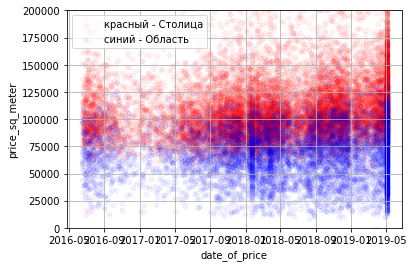

In [91]:
common_ax = data_df.query('locality_name == "Санкт-Петербург"').plot(
    kind='scatter', x='date_of_price', y='price_sq_meter', alpha=0.05, ylim=(0,200000), color='red', label='красный - Столица')

data_df.query('locality_name != "Санкт-Петербург"').plot( ax=common_ax, sharex=True, sharey=True,
    kind='scatter', x='date_of_price', y='price_sq_meter', alpha=0.05, ylim=(0,200000), color='blue', label='синий - Область')

plt.legend()
plt.grid()

Согласно Интернету, должен наблюдаться слабый неравномерный рост с 103 до 119 т.р. Точно утверждать трудно, так как замешанность сегментов слишком велика.

кстати, о замешенности: считать средние от цены за разные года по сегментам - это искусственно размывать распределения на (119-103)/110 = 14.5% !  Есть идея, поскольку наша задача предсказывать цены за квадрат на второе полугодие 2019 года - экстраполировать все цены к маю 2019 с учетом среднемесячной статистики  

In [92]:
avg_price_sq_meter_piter = {}
avg_price_sq_meter_region = {}
avg_half_period = 95//2 # взято время полупродажи квартиры

start_day = datetime(2016,6,16) + DateOffset(days=avg_half_period)

while start_day < (datetime(2019,5,3) - DateOffset(days=avg_half_period)): 
    first_day = start_day - DateOffset(days=avg_half_period)
    last_day = start_day + DateOffset(days=avg_half_period)
    
    avg_price_sq_meter_piter[start_day] = data_df.query(
        ' (@first_day < date_of_price < @last_day) & (locality_name == "Санкт-Петербург")')['price_sq_meter'].mean()
    avg_price_sq_meter_region[start_day] = data_df.query(
        ' (@first_day < date_of_price < @last_day) & (locality_name != "Санкт-Петербург")')['price_sq_meter'].mean()
    
    start_day = start_day + DateOffset(days=1) # это шаг словаря - проще для использования будет заполнять его каждым днем
# end of while body

# осталось заполнить хвосты, чтобы покрыть все дни диапазона значений date_of_price:
start_day = datetime(2016,6,16)  # левый хвост
while start_day < datetime(2016,6,16) + DateOffset(days=avg_half_period):
    avg_price_sq_meter_piter[start_day] = avg_price_sq_meter_piter[datetime(2016,6,16) + DateOffset(days=avg_half_period)]
    avg_price_sq_meter_region[start_day] = avg_price_sq_meter_region[datetime(2016,6,16) + DateOffset(days=avg_half_period)]
    start_day = start_day + DateOffset(days=1)

start_day = datetime(2019,5,3) - DateOffset(days=avg_half_period)  # правый хвост
while start_day <= datetime(2019,5,3):
    avg_price_sq_meter_piter[start_day] = avg_price_sq_meter_piter[datetime(2019,5,3) - DateOffset(days=avg_half_period+1)]
    avg_price_sq_meter_region[start_day] = avg_price_sq_meter_region[datetime(2019,5,3) - DateOffset(days=avg_half_period+1)]
    start_day = start_day + DateOffset(days=1)


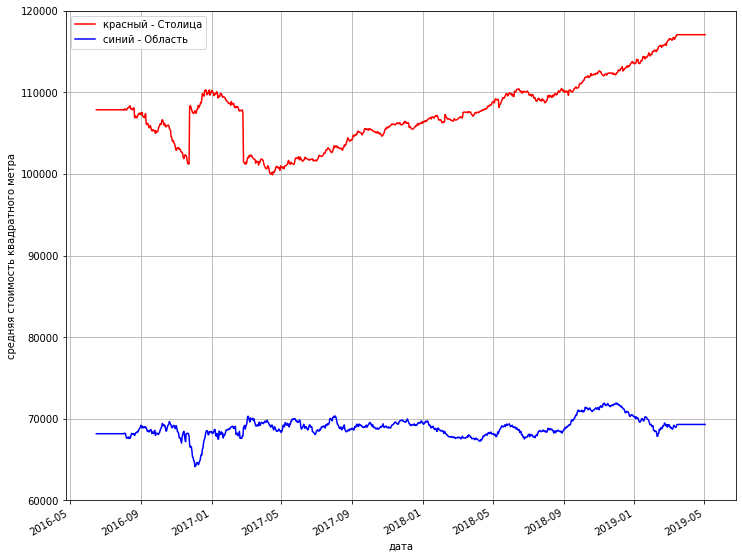

In [93]:
# посмотрим визуально как менялась средняя за время полупродажи цена квадратного метра:

avg_price_dict_df = pd.DataFrame(
    {
        'дата' : avg_price_sq_meter_piter.keys(), 
        'Столица' : avg_price_sq_meter_piter.values(), 
        'Область' : avg_price_sq_meter_region.values()
    }
) # перегоняем в дата фрейм, так как у Пандовской версии plot() больше возможностей визуализации, чеи у Матплотлибовской


common_ax = avg_price_dict_df.plot(
    kind='line', ylim=(60000,120000), figsize=(12,10),
    x='дата', y='Столица', color='red', label='красный - Столица')
avg_price_dict_df.plot(
    kind='line', ax=common_ax, sharex=True, sharey=True, ylabel='средняя стоимость квадратного метра', 
    x='дата', y='Область', color='blue', label='синий - Область')

plt.legend()
plt.grid()

Цены в области почти не имеют динамики и особенностей - видимо не рассматриваются как средство сохранения денег и/или инвестиций.  А вот цены в Питере ведут себя крайне динамично: на фоне двух линейных трендов, падения во втором полугодии 2016 на 7% и роста со второго квартала 2017 на 16% за два года, цены имеют особенность в первом квартале 2017:  вместо ожидаемого пересечения двух линейных трендов ниже 100 т.р. за квадрат, цены в данном квартале мгновенно подскакивают на 9% и остаются на одном уровне весь квартал!

Поскольку рубль в это время уверенно креп (согласно сайту ЦБ РФ), то видимо в этот период возникли какие-то инвестиционные ожидания относительно Питерской небвижимости, которые спасли цены от провала ниже 100 т.р. за квадрат в среднем.

Перед приведением цен с учетом временной динамики следует рассмотреть края (по 47 дней каждый) - сейчс значение там проставлено как последнее перед краем, но в случае явной линейной динамики Питерских цен такая экстраполяция не удачна - лучше мы линейно продолжим динамику в Питере на краях (слева наклон примерно 22 т.р. за год, справа - рост на 9 т.р. в год):

In [94]:
# переписываем хвосты, чтобы линейно экстраполировать зависимость в Питере по краям:

start_day = datetime(2016,6,16)  # левый хвост
corr_days = avg_half_period
while start_day < datetime(2016,6,16) + DateOffset(days=avg_half_period):
    avg_price_sq_meter_piter[start_day] = avg_price_sq_meter_piter[datetime(2016,6,16) + DateOffset(days=avg_half_period)] + (
                                          22000*corr_days/365)
    start_day = start_day + DateOffset(days=1)
    corr_days -= 1

start_day = datetime(2019,5,3) - DateOffset(days=avg_half_period)  # правый хвост
corr_days = 1
while start_day <= datetime(2019,5,3):
    avg_price_sq_meter_piter[start_day] = avg_price_sq_meter_piter[datetime(2019,5,3) - DateOffset(days=avg_half_period+1)] + (
                                          9000*corr_days/365)
    start_day = start_day + DateOffset(days=1)
    corr_days += 1

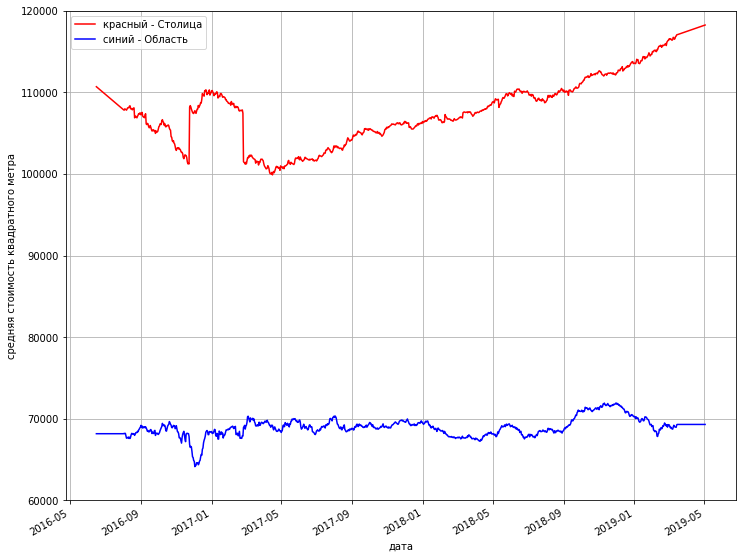

In [95]:
# проверяем визуально коррекцию динамики Питерских цен на хвостах (можно линейкой, варьируя 22000 и 9000 выше):

avg_price_dict_df = pd.DataFrame(
    {
        'дата' : avg_price_sq_meter_piter.keys(), 
        'Столица' : avg_price_sq_meter_piter.values(), 
        'Область' : avg_price_sq_meter_region.values()
    }
) # перегоняем в дата фрейм, так как у Пандовской версии plot() больше возможностей визуализации, чеи у Матплотлибовской


common_ax = avg_price_dict_df.plot(
    kind='line', ylim=(60000,120000), figsize=(12,10),
    x='дата', y='Столица', color='red', label='красный - Столица')
avg_price_dict_df.plot(
    kind='line', ax=common_ax, sharex=True, sharey=True, ylabel='средняя стоимость квадратного метра', 
    x='дата', y='Область', color='blue', label='синий - Область')

plt.legend()
plt.grid()

Наконец мы готовы пересчитать цены всех объявлений к приведенной с учетом динамики во времени.  Вводим для этого новый столбец `price_sq_meter_aligned`:

In [96]:
def price_aligned_linefunc(df):
    today = datetime(2019,5,3)
    date = df['date_of_price']
    price = df['price_sq_meter']
    piter = df['is_piter']
    
    if piter: return price * avg_price_sq_meter_piter[today] / avg_price_sq_meter_piter[date]
    else: return price * avg_price_sq_meter_region[today] / avg_price_sq_meter_region[date]
    
data_df['price_sq_meter_aligned'] = data_df.apply(price_aligned_linefunc, axis=1)

сравним визуально результат:

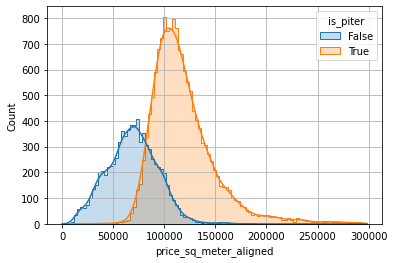

In [97]:
sns.histplot(x='price_sq_meter_aligned', data=data_df[data_df['price_sq_meter_aligned']<300000], hue='is_piter', 
             element='step', kde = True)
plt.grid()

получше гистограмма стала прилегать к kde-кривой, особенно в Питере! (или мне кажется?)

### Зависимость цены от расстояния до центра и категория удаленности как параметр сегментации цен

также наконец-то можем посмотреть на зависимость цены от расстояния до центра

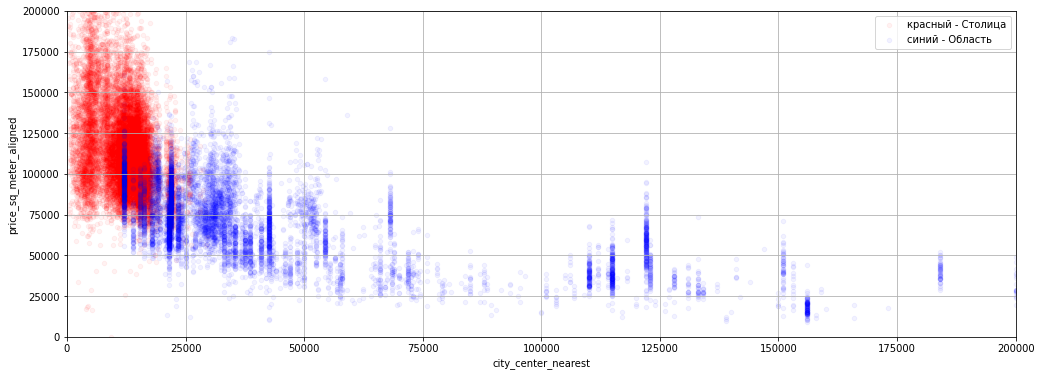

In [98]:
common_ax = data_df.query('is_piter').plot( ylim=(0,200000), xlim=(0,200000), figsize=(17,6),
    kind='scatter', x='city_center_nearest', y='price_sq_meter_aligned', alpha=0.05, color='red', label='красный - Столица')

data_df.query('~is_piter').plot( ax=common_ax, sharex=True, sharey=True,
    kind='scatter', x='city_center_nearest', y='price_sq_meter_aligned', alpha=0.05, color='blue', label='синий - Область')

plt.legend()
plt.grid()

видимо, в Питере нет такой разницы в ценах за квадрат в зависимости от факта снаружи или внутри МКАД - распределение в области подхватывает и продолжает тренд Питерских цен с разницей не более 10-20% в переходной зоне 12-17 км.  В области видны отдельные крупные города, где больше объявлений - хотя они и смотрятся как спектральные полосы, но следует понимать, что это из-за заполнения пропусков в столбце city_center_nearest средними значениями по населенным пунктам.  Реально каждый такой город должен быть размазан на свой характерный размер - от 5 до 20 км, но такая тщательность в предобработке выходит за врременные рамки и учебный характер данного проекта. 

Видно, что монотонный тренд до радиуса порядка 50 км сменяется на скачки возле уровня 50 т.р. за квадратный метр - далее в области цена определяется уже привлекательностью населенного пункта, а не расстоянием до центра

внесем окончательные правки в идею визуально категоризовать объевления по расстоянию на четкие группы:
* `центр           -` 0-7 км (центральное кольцо города)
* `спальные районы -` 7-17 км (Питер)
* `окраина         -` > 17 км (Питер)
* `за кольцевой    -` < 25 км (Область)
* `пригород        -` 25-35 км
* `ближняя область -` 35-50 км 
* `дальняя область -` > 50 км (отдельные пики определены просто географическим разбросом населенных пунктов по карте)

обратим внимание, что по факту категоризация идет по двум параметрам - расстояние и столица/область, которые сводятся в одну категорию!

Сразу проведем категоризацию - добавим столбец с категорией удаленности `remote_cat`):

In [99]:
def remote_cat_linefunc(df):
    distance = df['city_center_nearest']
    location = df['locality_name']
    
    if location == 'Санкт-Петербург':
        if distance <= 7000: return '1-кат центр'
        elif distance <= 17000: return '2-кат спальные районы'
        else: return '3-кат окраина'
    else:
        if distance <= 25000: return '4-кат за кольцевой'
        elif distance <= 35000: return '5-кат пригород'
        elif distance <= 50000: return '6-кат ближняя область'
        else: return '7-кат дальняя область'

data_df['remote_cat'] = data_df.apply(remote_cat_linefunc, axis=1)

data_df['remote_cat'].value_counts()

2-кат спальные районы    10903
1-кат центр               3102
4-кат за кольцевой        2878
7-кат дальняя область     2004
5-кат пригород            1722
3-кат окраина             1293
6-кат ближняя область     1250
Name: remote_cat, dtype: int64

хорошие выборки по всем сегментам (пока - есть и другие категории).  Названия категорий пришлось начать с цифры - чтобы управлять порядком вывода функцией df.pivot_table

### Категории однушки и первый-последний этаж, уточнение категории удаленности

следующей категорией, вроде бы, явлается кол-во комнат:

In [100]:
price_rooms_vs_remote_pvt = data_df.pivot_table(
    columns='remote_cat', index='rooms', values='price_sq_meter_aligned', aggfunc='mean')

display(price_rooms_vs_remote_pvt)

remote_cat,1-кат центр,2-кат спальные районы,3-кат окраина,4-кат за кольцевой,5-кат пригород,6-кат ближняя область,7-кат дальняя область
rooms,,,,,,,
1,158795.798881,121968.356972,106840.450005,86209.010173,84953.526723,67149.805494,49619.602739
2,143324.161115,114440.020531,101255.409722,77325.938171,79048.618236,60438.286430,43187.692048
3,136447.505405,108664.909904,88438.243138,71169.085545,76628.490917,59538.688077,43317.546268
4,126851.626289,107421.176063,85386.101861,61805.690217,77345.629140,61666.315512,49430.433874
5,123463.019825,110977.333529,92117.775562,66563.858041,80025.716632,54317.818404,43413.758325


Заметим, что прослеживается четкий тренд цен по категории удаленности, кроме 4-й и 5-й категорий - их объединяем:

In [101]:
def join_4and5_rename_6and7_linefunc(df):
    category = df['remote_cat']
    
    if (category == '4-кат за кольцевой') or (category == '5-кат пригород'): return '4-кат пригород'
    elif category == '6-кат ближняя область': return '5-кат ближняя область'
    elif category == '7-кат дальняя область': return '6-кат дальняя область'
    else: return category

data_df['remote_cat'] = data_df.apply(join_4and5_rename_6and7_linefunc , axis=1)

In [102]:
price_rooms_vs_remote_pvt = data_df.pivot_table(
    columns='remote_cat', index='rooms', values='price_sq_meter_aligned', aggfunc='mean')

display(price_rooms_vs_remote_pvt)

remote_cat,1-кат центр,2-кат спальные районы,3-кат окраина,4-кат пригород,5-кат ближняя область,6-кат дальняя область
rooms,,,,,,
1,158795.798881,121968.356972,106840.450005,85856.967774,67149.805494,49619.602739
2,143324.161115,114440.020531,101255.409722,78046.441553,60438.286430,43187.692048
3,136447.505405,108664.909904,88438.243138,73873.629681,59538.688077,43317.546268
4,126851.626289,107421.176063,85386.101861,72067.914034,61666.315512,49430.433874
5,123463.019825,110977.333529,92117.775562,75742.397989,54317.818404,43413.758325


теперь категория удаленности является отличной основой для сегментации цены, а вот количество комнат не домострирует убедительных трендов, кроме того, что однушки подороже, поэтому вводим категорию `is_1room_cat`

In [103]:
data_df['is_1room_cat'] = data_df['rooms'] == 1 # True - если однушка и False иначе 

In [104]:
price_1room_vs_remote_pvt = data_df.pivot_table(
    columns='remote_cat', index='is_1room_cat', values='price_sq_meter_aligned', aggfunc='mean')

for col in price_1room_vs_remote_pvt.columns:
    price_1room_vs_remote_pvt.loc['delta in %', col] = round(200 * \
        (price_1room_vs_remote_pvt.loc[True, col] - price_1room_vs_remote_pvt.loc[False, col]) / \
        (price_1room_vs_remote_pvt.loc[True, col] + price_1room_vs_remote_pvt.loc[False, col]) , 1)

display(price_1room_vs_remote_pvt)

remote_cat,1-кат центр,2-кат спальные районы,3-кат окраина,4-кат пригород,5-кат ближняя область,6-кат дальняя область
is_1room_cat,,,,,,
False,135759.752106,111656.690429,95175.736340,76267.666840,60119.947909,43552.198006
True,158795.798881,121968.356972,106840.450005,85856.967774,67149.805494,49619.602739
delta in %,15.600000,8.800000,11.500000,11.800000,11.000000,13.000000


Заметим, что однушки пользуются повышенным спросом в самой дорогой и в самой дешевой категориях.  Предполагаемые причины:
* в центре - молодые специалисты с хорошим доходом
* на периферии - самое дешевое отдельное жилье из всех возможных, клиенты - дауншифтеры и иммигранты
а вот у среднего класса средних лет популярны спальные районы и многокомнатные квартиры (минимальный бенефит цены за однушку)

Этого достаточно для сегментации по кол-ву комнат, но на графиках цены от расстояния мы видели широкий разброс цен - поищем еще категории для других измерений сегментации цены.  

Как уже говорилось, разумно попробовать ввести категорию `first_last_floor_cat`:

In [105]:
def first_last_floor_cat(df):
    f = df['floor']
    ft = df['floors_total']
    
    if (f == 1) or (f == ft): return True
    else: return False
    
data_df['first_last_floor_cat'] = data_df.apply(first_last_floor_cat,axis=1)

In [106]:
price_first_last_vs_remote_pvt = data_df.pivot_table(
    columns='remote_cat', index='first_last_floor_cat', values='price_sq_meter_aligned', aggfunc='mean')

for col in price_first_last_vs_remote_pvt:
    price_first_last_vs_remote_pvt.loc['delta in %', col] = - round(200 * \
        (price_first_last_vs_remote_pvt.loc[True, col] - price_first_last_vs_remote_pvt.loc[False, col]) / \
        (price_first_last_vs_remote_pvt.loc[True, col] + price_first_last_vs_remote_pvt.loc[False, col]) , 1)

display(price_first_last_vs_remote_pvt)

remote_cat,1-кат центр,2-кат спальные районы,3-кат окраина,4-кат пригород,5-кат ближняя область,6-кат дальняя область
first_last_floor_cat,,,,,,
False,143366.885665,117661.604457,101994.622427,82560.794470,65209.971205,48128.029041
True,129551.158502,106422.298739,93549.451712,76102.654642,58783.249807,41910.234551
delta in %,10.100000,10.000000,8.600000,8.100000,10.400000,13.800000


тоже расширяет разброс цен на 10% - посмотрим ценовые зависимости отдельно по каждому набору категорий `is_1room_cat` и `first_last_floor_cat`, чтобы не забивать все графиками, опять будем делить на Питер и Область:

In [107]:
# сперва добавим совместную категорию одним столбцом:
def join_cat_floor_room(df): 
    fc = df['first_last_floor_cat']
    rc = df['is_1room_cat']
    return (rc, fc)
data_df['1room_vs_1st-last'] = data_df.apply(join_cat_floor_room, axis=1) 

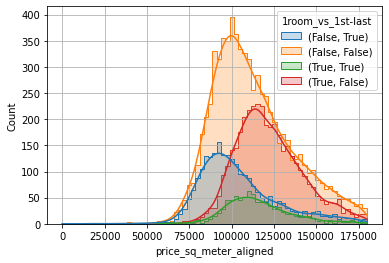

In [108]:
sns.histplot(x='price_sq_meter_aligned', 
             data=data_df.query('is_piter & price_sq_meter_aligned < 180000'), 
             element='step', kde = True, 
             hue='1room_vs_1st-last', hue_order=[(False,True), (False,False), (True,True), (True,False)])
plt.grid()

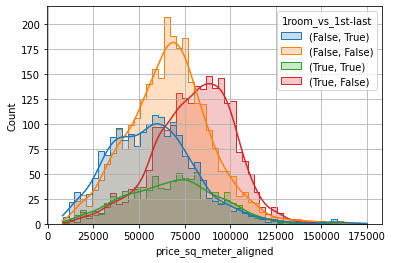

In [109]:
sns.histplot(x='price_sq_meter_aligned', 
             data=data_df.query('~is_piter & price_sq_meter_aligned < 180000'), 
             element='step', kde = True, 
             hue='1room_vs_1st-last', hue_order=[(False,True), (False,False), (True,True), (True,False)])
plt.grid()

как ожидалось, в порядке повышения спроса идут: 
* многокомнатные первый-последний этаж - СИНИЙ
* многокомнатные промежуточные этажи - ОРАНЖЕВЫЙ
* однушки первый-последний этаж - ЗЕЛЕНЫЙ
* однушки промежуточные этажи - КРАСНЫЙ

для тех, кто хочет купить однушку факт отдельности квартиры превалирует над фактом крайнего этажа

### Влияние зеленой зоны и близости места для прогулок - green_mile и walking_dist

Как планировалось, сведем пять параметров - близость аэропорта, кол-ва парков и водоемов, близость прогулочных мест в две категории:
* `green_mile` - смоделируем так: возьмем сумму количеств парков и водоемов, ограничим (0,1,2,3) потом вычтем поправку на близость аэропорта
* `walking_dist` - минимум из расстояний до парка и водоема

Осторожно с NaN !  NB!: у столбца расстояния до аэропорта NaN был превращен в 0.0 при предобработке

#### Зеленая зона

In [110]:
def green_mile_linefunc(df):
    ap_dist = df['airport_nearest']
    no_of_parks = df['parks_around3000']
    no_of_ponds = df['ponds_around3000']
    ap_dist_lim = 5000 # если аэропорт ближе этого расстояния, то минус балл к рейтингу зеленой зоны 
    
    if not (no_of_parks >= 0.0): return no_of_parks # NaN-ы сразу возвращаем, так как с ними нельзя работать
    if not (no_of_ponds >= 0.0): return no_of_ponds # аналогично
    
    result = int(no_of_parks) + int(no_of_ponds) # флот сразу конвертим инт до операции сложения - чтобы избежать округлений
    
    if result > 3: result = 3 # нет разницы 4 или 5 парков рядом!
    
    if (result > 0) & (ap_dist != 0.0):
        if ap_dist < ap_dist_lim: result -= 1
            
    return result
    
data_df['green_mile'] = data_df.apply(green_mile_linefunc,axis=1)

In [111]:
data_df['green_mile'].value_counts()

0.0    5759
1.0    5577
2.0    3322
3.0    3093
Name: green_mile, dtype: int64

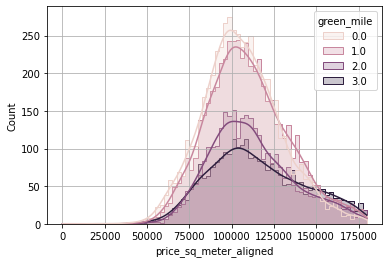

In [112]:
sns.histplot(x='price_sq_meter_aligned', 
             data=data_df.query('price_sq_meter_aligned < 180000'), 
             element='step', kde = True, 
             hue='green_mile', hue_order=(0,1,2,3))
plt.grid()

Хотя пик цены не сдвигается, мы видим, что в области бОльших цен распределение зеленых цен становится толще, чем у неэкологичных.  Можно предположить, что в сегменте высоких цен фактор зеленой зоны играет большую роль.  Поменяем тип графика на box-and-whisker: 

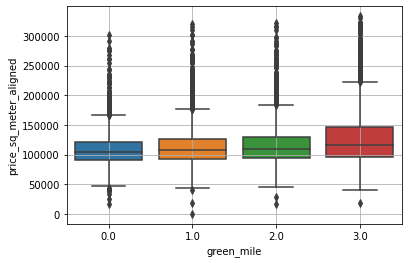

In [113]:
sns.boxplot(x='green_mile', y='price_sq_meter_aligned', data=data_df)
plt.grid()

также проверено по сегментам категории удаленности - везде аналогичная картина: похоже, что в любом сегменте рынка присутствуют в небольшом количестве люди, которым важен параметр экологичности.  Именно они тащат хвост в сторону больших цен для зеленой зоны, но как видом, влияние не велико: 

In [114]:
price_vs_green_pvt = data_df.pivot_table(index='green_mile', values='price_sq_meter_aligned', aggfunc=('mean','median'))
display(price_vs_green_pvt)

,mean,median
green_mile,,
0.0,107493.292754,104957.491270
1.0,112833.574766,108460.985630
2.0,116839.567218,109946.131649
3.0,126611.226811,116318.208642


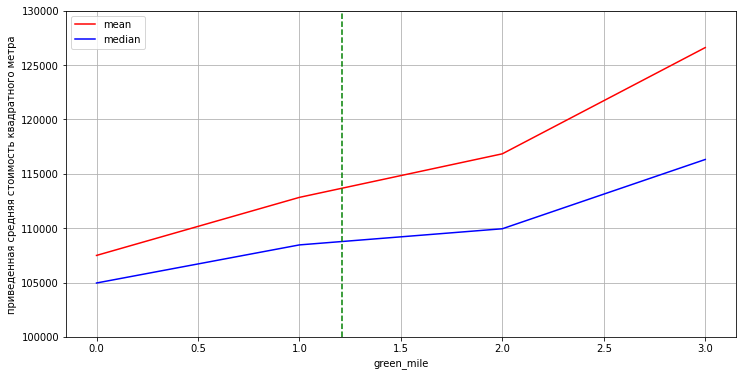

In [115]:
common_ax = price_vs_green_pvt.plot(
    kind='line', ylim=(100000,130000),figsize=(12,6), 
    y='mean', color='red', label='mean')

price_vs_green_pvt.plot(
    kind='line', ax=common_ax, sharex=True, sharey=True, ylabel='приведенная средняя стоимость квадратного метра', 
    y='median', color='blue', label='median')

avg_green_mile = data_df['green_mile'].mean()
plt.plot((avg_green_mile, avg_green_mile), (100000,130000), color='green', linestyle='--')

plt.legend()
plt.grid()

пунктиром показано среднее значение параметра зеленой зоны. Значение средней цены в точке пересечения 113670 рублей (определяется изменением масштаба по оси Y графика выше), соответственно создаем словарь поправок на зеленую зону:

In [116]:
green_mile_corr_dict = {}
for i in (0,1,2,3):
    green_mile_corr_dict[i] = (price_vs_green_pvt.loc[float(i),'mean']-113670)/113670

print(green_mile_corr_dict )

{0: -0.05433893943886854, 1: -0.007358363981037451, 2: 0.027883937869846595, 3: 0.11384909660519461}


Соответственно, после того, как цена нулевого приближения $P_0$ определена по сегменту, определяем поправку к ней в процентах подставляя в данный словарь вместо ключа значение зеленой зоны для искомого объекта: $$P_1 (green \_ mile) = P_0 * green \_ mile \_ corr \_ dict \space [ green \_ mile ] $$

#### Близость места прогулок

In [117]:
def w_dist_linefunc(df):
    dpark = df['park_nearest']
    dpond = df['pond_nearest']
    
    if ( not dpark >= 0.0) and (not dpond >= 0.0): return dpark # обработка NaN-в
    if not dpark >= 0.0: return dpond # если один NaN, а другой не NaN, то возвращается неNaN
    if not dpond >= 0.0: return dpark # аналогично

    return min([dpark,dpond])

data_df['walking_dist'] = data_df.apply(w_dist_linefunc,axis=1)

In [118]:
data_df['walking_dist'].describe()

count    11992.000000
mean       449.953386
std        257.967005
min          1.000000
25%        245.000000
50%        431.000000
75%        613.000000
max       1942.000000
Name: walking_dist, dtype: float64

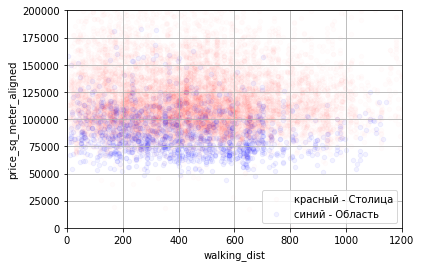

In [119]:
common_ax = data_df.query('is_piter').plot(
    kind='scatter', x='walking_dist', y='price_sq_meter_aligned', alpha=0.01, 
    ylim=(0,200000), xlim=(0,1200), 
    color='red', label='красный - Столица')

data_df.query('~is_piter').plot( ax=common_ax, sharex=True, sharey=True,
    kind='scatter', x='walking_dist', y='price_sq_meter_aligned', alpha=0.05,  
    color='blue', label='синий - Область')

plt.legend()
plt.grid()

так трудно посчитать поправку - попробуем по-другому: разобьем первый километр по 100 метров и посчитаем среднюю цену в каждом интервале:

In [120]:
def walking_zone_linefunc(df):
    wd = df['walking_dist']
    
    if not (wd >= 0.0): return wd # NaN handling
    
    for i in range(100,2001,100): 
        if wd <= i: return i
    
    return 2000
    
data_df['walking_zone'] = data_df.apply(walking_zone_linefunc, axis=1)

In [121]:
data_df['walking_zone'].value_counts().head(15)

500.0     1770
400.0     1635
600.0     1603
300.0     1522
200.0     1406
700.0     1286
100.0      864
800.0      688
900.0      527
1000.0     395
1100.0     147
1200.0      82
1300.0      44
1400.0      12
1500.0       4
Name: walking_zone, dtype: int64

In [122]:
price_vs_wzone_pvt = data_df.pivot_table(index='walking_zone', columns='is_piter', values='price_sq_meter_aligned', aggfunc=('mean'))

price_vs_wzone_df = pd.DataFrame(
    {
        'walking_zone' : price_vs_wzone_pvt.index,
        'Столица' : list(price_vs_wzone_pvt[True]),
        'Область' : list(price_vs_wzone_pvt[False])
    }
)

In [123]:
display(price_vs_wzone_df)

,walking_zone,Столица,Область
0,100.0,128662.288311,93823.414654
1,200.0,125447.498491,89364.468842
2,300.0,122305.443961,89019.213261
3,400.0,121412.488932,90055.441037
4,500.0,120709.677548,85316.567282
5,600.0,119519.520918,83511.973661
6,700.0,118679.921244,80343.949642
7,800.0,118647.457051,83404.541954
8,900.0,119919.130552,79603.635412
9,1000.0,113755.335090,80561.776419


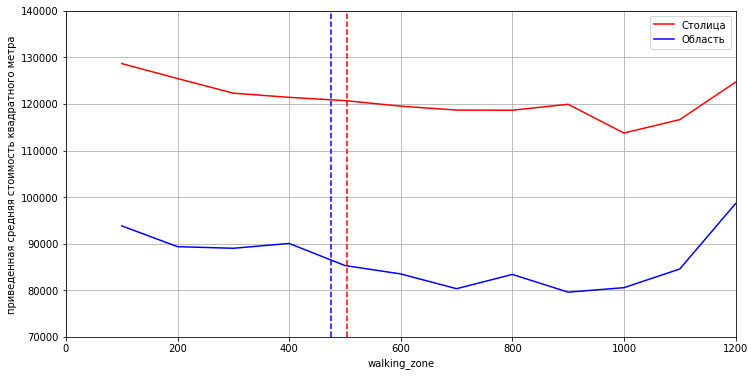

In [124]:
price_vs_wzone_df = price_vs_wzone_df.dropna()

common_ax = price_vs_wzone_df.plot(
    kind='line', ylim=(70000,140000),xlim=(0,1200), figsize=(12,6), 
    x='walking_zone', y='Столица', color='red', label='Столица')

price_vs_wzone_df.plot(
    kind='line', ax=common_ax, sharex=True, sharey=True, ylabel='приведенная средняя стоимость квадратного метра', 
    x='walking_zone', y='Область', color='blue', label='Область')

avg_wzone_piter = data_df.query('is_piter')['walking_zone'].mean()
plt.plot((avg_wzone_piter, avg_wzone_piter), (70000,140000), color='red', linestyle='--')

avg_wzone_region = data_df.query('~is_piter')['walking_zone'].mean()
plt.plot((avg_wzone_region, avg_wzone_region), (70000,140000), color='blue', linestyle='--')

plt.legend()
plt.grid()

Пунктирами соответствующего цвета опять показаны средние значения

зависимости не вдохновляют, хотя рост в районе < 300 метров достаточно убедительно выглядит.  Предлагается отразить в совсем упрощенной категории `is_walking`, равный True, если меньше 500 и False - если больше

In [125]:
def walking_linefunc(df):
    wd = df['walking_dist']
    
    if not (wd >= 0.0): return wd # NaN handling
    
    if wd <= 500: return True
    else: return False
    
data_df['is_walking'] = data_df.apply(walking_linefunc, axis=1)

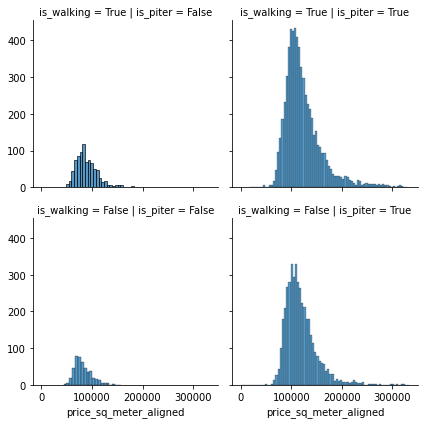

In [126]:
g = sns.FacetGrid(data_df, row='is_walking', col='is_piter')
g.map(sns.histplot,'price_sq_meter_aligned')
plt.show()


и пивот-таблица со средними, соответствующими расположению сегментов матрицы гистограмм:

In [127]:
price_vs_walk_pvt = data_df.pivot_table(columns='is_piter', index='is_walking', values='price_sq_meter_aligned', aggfunc='mean')

print('                               | Область | Столица')
print('____________________________________________________\n')
print('Ср.цена кв.метра с прогулкой:  | ',int( price_vs_walk_pvt.loc[True,False]),' | ', int(price_vs_walk_pvt.loc[True,True]))
print('____________________________________________________\n')
print('Ср.цена кв.метра без прогулки: | ',int(price_vs_walk_pvt.loc[False,False]),' | ', int(price_vs_walk_pvt.loc[False,True]))
print('____________________________________________________\n')
print('Относительная разница в ценах: | ',
    round(200*((price_vs_walk_pvt.loc[True,False]-price_vs_walk_pvt.loc[False,False]))/
    ((price_vs_walk_pvt.loc[True,False]+price_vs_walk_pvt.loc[False,False])),2), '%'
    ' | ',
    round(200*((price_vs_walk_pvt.loc[True,True]-price_vs_walk_pvt.loc[False,True]))/
    ((price_vs_walk_pvt.loc[True,True]+price_vs_walk_pvt.loc[False,True])),2), '%'
)

                               | Область | Столица
____________________________________________________

Ср.цена кв.метра с прогулкой:  |  89130  |  123076
____________________________________________________

Ср.цена кв.метра без прогулки: |  82251  |  118694
____________________________________________________

Относительная разница в ценах: |  8.03 % |  3.62 %


таким образом, искомая поправка в ценах задается walking_corr_df: $$P_1 (walking \_ area) = P_0 * walking \_ corr \_ df.loc \space [ is \_ walking \space , \space is \_ piter ] $$


In [128]:
walking_corr_df = pd.DataFrame(
    data=[
        [0.040 , 0.018],
        [-0.040, - 0.018]
    ],
    index=(True, False),
    columns = (False, True)
)

In [129]:
display(walking_corr_df)

,False,True
True,0.04,0.018
False,-0.04,-0.018


In [130]:
print(f'пример использования - получим поправку на доступность пеших прогулок в Питере: {walking_corr_df.loc[True, True]}')

пример использования - получим поправку на доступность пеших прогулок в Питере: 0.018


### Поправки на параметры `balconies`, `is_studio`, `is_open_plan` 
определяются точно также, как было проделано для параметров зеленой зоны и доступности пеших прогулок - нет смысла загромождать и без того огромный проет посторением одинаковых действий (мы все же ограничены неделей на выполнение).  Лучше обратиться к двум принципиальным вопросам, оставшимся вне анализа до сих пор - это:

* влияние параметров высоты потолков и доли жилой площади и кухни на стоимость квадрата 
* рассмотрение уровня цен в первом десятке областных городов

### Параметры типа строительного объекта: высота потолков, доля жилой площади и кухни

Как было замечено после первичного ознакомления с данными, в исходных данных отсутствует прямая информация по типу строительного объекта, хотя именно он является ключевым среди рассматриваемых риэлтерами.  поэтому рассматривать строительные параметры по линейной эсктраполяции, как мы делали для зеленой зоны и доступности пеших прогулок - плохая идея: при этом мы замешаем в одно хрущевки, башни-брежневки, сталинки и пр.  

Но к счастью типов домов все же конечное кол-во и можно надеятся на сильную стратификацию параметров. Проверим эту гипотезу на матрице `rooms x floors_total`, а стратифицировать будем по общей площади - другого полного параметра с характеристикой строительного объекта у нас нет!

Но сперва урежем наш датасет только наиболее частыми значениями этих параметров (иначе статистический разброс исказит картину):
* rooms in (1, 2, 3)
* floors_total in (5, 9, 16, 12) 
* total_area < 100

In [131]:
cut_df = data_df.query('( rooms in (1,2,3) ) & ( floors_total in (5,9,16,12)) & (total_area < 100)')
len(cut_df['rooms'])
cut_df.pivot_table(index='rooms', columns='floors_total', values='floor', aggfunc='count')

floors_total,5,9,12,16
rooms,,,,
1,1424,1132,512,623
2,2291,1236,434,397
3,1386,1136,327,233


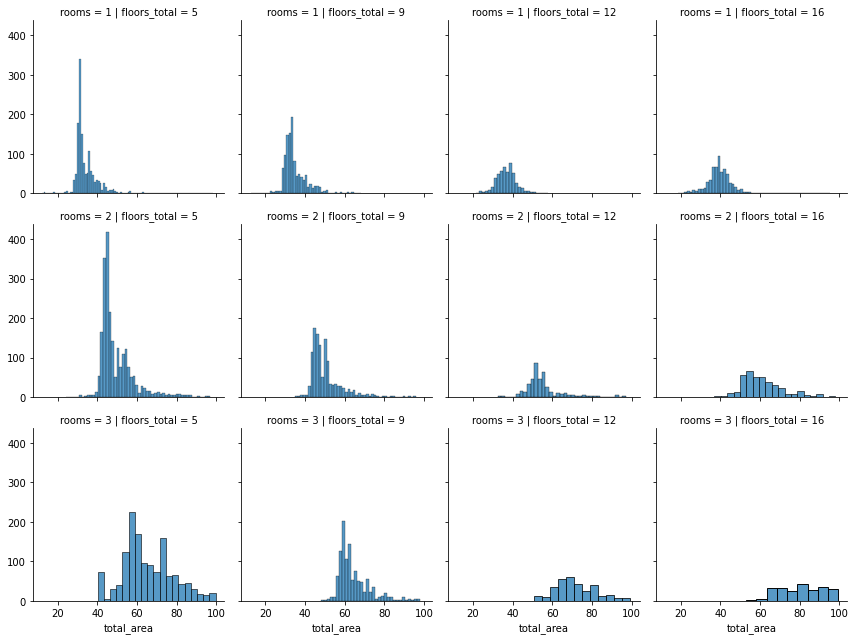

In [132]:
g = sns.FacetGrid(cut_df, row='rooms', col='floors_total')
g.map(sns.histplot,'total_area')
plt.show()

да, для такой сегментации уже не хватает данных - попробуем все же довести до конца для самого многочисленого сегмента - двушки в пятиэтажках:

2291


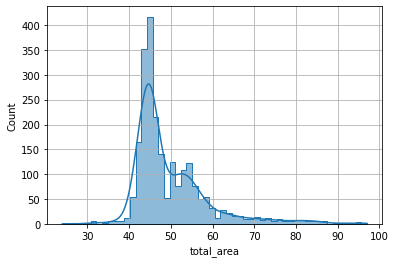

In [133]:
cut_df = cut_df.query('(rooms == 2) & (floors_total == 5)')
print(len(cut_df['rooms']))

sns.histplot(x='total_area', data=cut_df, element='step', kde = True)
plt.grid()

Данные, конечно, совершенно удивительные - двушки меньше 30 метров и больше 80!  Это какие-то питерские пятиэтажки!
Видим только 2 типовых площади 42-47 и 50-57

1514


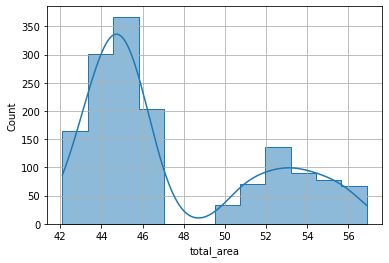

In [134]:
cut_df = cut_df.query('(42 < total_area < 47) | (50 < total_area < 57)')
print(len(cut_df['rooms']))

sns.histplot(x='total_area', data=cut_df, element='step', kde = True)
plt.grid()

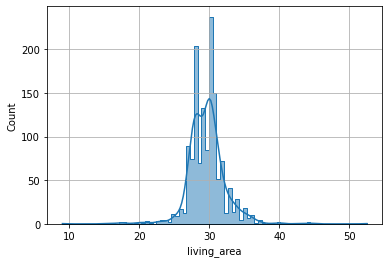

In [135]:
sns.histplot(x='living_area', data=cut_df, element='step', kde = True)
plt.grid()

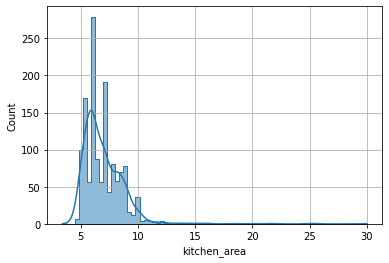

In [136]:
sns.histplot(x='kitchen_area', data=cut_df, element='step', kde = True)
plt.grid()

проверим гипотезу типовых квартир - оставим поочереди только один тип и посмотрим как поменяются графики    

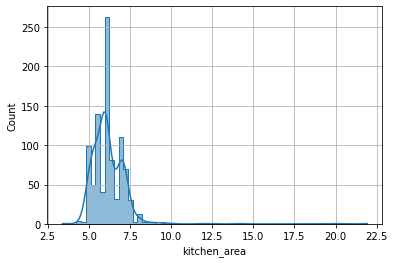

In [137]:
sns.histplot(x='kitchen_area', data=cut_df.query('42 < total_area < 47'), element='step', kde = True)
plt.grid()

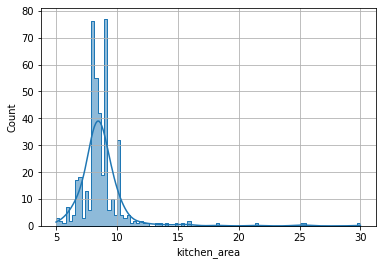

In [138]:
sns.histplot(x='kitchen_area', data=cut_df.query('50 < total_area < 57'), element='step', kde = True)
plt.grid()

ну можно сказать, что там две типовых двушки - малая и средняя, у малой кухня 6 метров, у большой 8 метров.  Но совершенно необъясним разброс в метраже - люди не могут указывать метраж кухни с ошибкой +/- 3 метра!  Не говоря уже про выбросные значения - в ходе какого стечения обстоятельств в базу могла попасть двушка в пятиэтажке с кухней до 50% от общей площади?

**Вывод:** типизация жилья по этажности дома и общей площади не работает, возможно не хватает параметров - года постройки дома, хотя бы.  В итоге рассматривать доли площади кухни и жилой площади являются симуляцией статистики - люди выбирают конкретную площадь кухни и комнат, но не доли.  А зайти на сегментацию цены со стороны типа дома не получается по причине недостаточности информации о строительном объекте.

### Исследование цен в крупных областных городах

Будем предполагать, что в крупных областных городах и объявлений больше, поэтому составим их список (удалив Питер)

In [139]:
list_of_towns = list(data_df['locality_name'].value_counts().head(11).index)
list_of_towns.remove('Санкт-Петербург')
list_of_towns

['Мурино',
 'Кудрово',
 'Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'Парголово',
 'Гатчина',
 'Выборг',
 'Петергоф']

Создадим датафрейм только с записями, относящимися к ним

In [140]:
towns_df = data_df.query('locality_name in @list_of_towns')

In [141]:
towns_price_pvt = towns_df.pivot_table(index='locality_name', values='price_sq_meter_aligned', aggfunc=['mean', 'median'])
display(towns_price_pvt)

,mean,median
,price_sq_meter_aligned,price_sq_meter_aligned
locality_name,,
Всеволожск,67302.845847,65872.771422
Выборг,58271.088783,58486.945888
Гатчина,69005.203173,68272.706116
Колпино,75558.408866,74749.893876
Кудрово,95547.147765,95475.576421
Мурино,86024.032219,85991.934470
Парголово,90342.129617,92358.673230
Петергоф,84354.564895,82296.049129


,mean,median
,price_sq_meter_aligned,price_sq_meter_aligned
locality_name,,
Пушкин,102299.524637,100000.000000
Кудрово,95547.147765,95475.576421
Парголово,90342.129617,92358.673230
Мурино,86024.032219,85991.934470
Петергоф,84354.564895,82296.049129
Шушары,78708.410803,76948.596376
Колпино,75558.408866,74749.893876
Гатчина,69005.203173,68272.706116


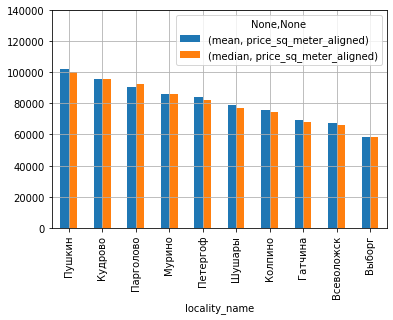

In [142]:
display(towns_price_pvt.sort_values(by=('mean','price_sq_meter_aligned'), ascending=False))

towns_price_pvt.sort_values(by=('mean','price_sq_meter_aligned'), ascending=False).plot(kind='bar',ylim=(0,140000))
plt.grid()

**Вывод:** цены в Пушкине не уступают Питерским в спальных районах

## Заключение по проведенному проекту

### Замечания об исходных данных

1. В таблице нет достоверных данных о цене фактической продажи объекта недвижимости. Опыт общения с риэлтерами показывает, что она может отличаеться от объявления.

2. Кроме того в таблице присутствуют цены валидные в разные промежутки времени - точно даже нельзя сказать какие, так как цена заявлена как последняя, а из временных параметров присутствует только дата публикации и время экспозиции, последнее присутствует не во всех данных.  Отсутствие времени экспозиции можно толковать как "еще валидно" и как "забыли внести".  В целом это не позволяет даже уверенно пересчитать цены к последней дате с учетом средней динамики во времени.

3. В таблице нет даже информации о том, состоялась ли сделка. Поэтому даже косвенный параметр времени экспозиции, позволяющий косвенно судить о близости цены к рыночной, не является достоверным.

4. В таблице присутствуют странные параметры близости к аэропорту, паркам и прудам, но отсутствует расстояние до станции метро/пригородной электрички и название ветки метро/пригородного сообщения.

5. Расстояние до центра города также должно измераться не в километрах, а в минутах езды общественным транспортом - в различных микрорайонах ситуация разная, даже на одинаковом гео-расстоянии от центра.  Данные по расстоянию в исходном датасете неполны, хотя это тоже центральный параметр цены

6. В таблице нет типа (многоквартирного) дома и года его постройки - очень существенный параметр цены жилой недвижимости в крупном городе.  из информации воб обекте как строительном полностью присутствует только общая площадь, кол-во комнат и этажность дома. Данные о высоте потолков, жилой площади и кухне неполны

7. Нет информации о наличии автостоянки на территории дома и о закрепленности места на ней за объектом (ее платности/бесплатности и пр)

8. Только по 9% населенных пунктов, упомянутых в таблице, присутствуют указание расстояния до центра, также при ручном заполнении замечено, что по ряду населенных пунктов присутствующие данные о расстоянии не соответствуют действительности - например среднее расстояние по Кронштадту указано в районе 52 км, тогда как по карте линейкой 30 км 

9. Значение информации в столбце "апартаменты" не яснО, да и данных совсем мало (9% от исходного датасета) - в текущем виде данный столбец совсем не годится для анализа

10. Дупликатов данных нет


### Отчет о проведенной работе

1. Детально изучен исходный датасет, проведена его предобработка включая:
 * удаление менее 2.2% строк, с отсутствием критических данных, либо представляющих из себя статистически ничтожные хвосты
 * восстановление данных по расстоянию до центра (с использованием сервиса Яндекс.Карты)
 * укрупнены категории по нахождению объекта в зеленой зоне и по близости прогулочной зоны
 * проведена предварительная сегментация цен
 * удаление неявных дупликатов из столбца с названиями населенных пунктов и ручное определение расстояний до центра для 285 из них

2. Введены новые параметры записей - более соответствующие поставленным задачам - включая:
 * цена квадратного метра в объявлении
 * дата актуальности цены в объявлении
 * приведенная цена квадратного метра на 03-мая-2019 - с учетом временной динамики усредненой по датасету
 * категория "удаленности объекта" сегментирующая цены на 6 непересекающихся ценовых диапазона:

In [143]:
data_df.pivot_table(columns='remote_cat', values='price_sq_meter_aligned', aggfunc='mean')

remote_cat,1-кат центр,2-кат спальные районы,3-кат окраина,4-кат пригород,5-кат ближняя область,6-кат дальняя область
price_sq_meter_aligned,139287.193182,115389.621535,100074.374793,80810.077,62577.58612,45205.293308


(продолжение списка)
 * категория "однушка" - по результатам исследования включена в сегментацию, как дающая эффект на уровне 10-15%
 * категория "крайний этаж" - по результатам исследования включена в сегментацию, как дающая эффект на уровне 10%
 * категория "зеленая зона" - объединившая и заменившая три столбца данных: количества парков и прудов в 3-х километровой зоне и отсутствия аэропорта в 5-и километровой зоне 
 * категория "прогулочная зона"- объединившая и заменившая два столбца данных: расстояния до парка и расстояние до пруда
 
3. Проанализированы в графической и табличной формах зависимости:
 * цены квадратного метра в период с 16-06-2016 по 03-05-2019
 * гистограммы распределений объявлений по приведенным ценам - отдельно Питер и Область
 * диаграммы рассеяния цен для зависимости от расстояния до центра - отдельно Питер и Область
 * зависимость от крайнего этажа и кол-ва комнат - все варианты гистограмм распределений объявлений по приведенным ценам - отдельно Питер и Область
 * внияние факторов зеленой и прогулочных зон на цены

4. Предложены и реализованы методологии:
 * восстановления отсутствующей информации о расстоянии до центра (по средней величине по населенному пункту- либо рассчитываемой по имеющимся данным, либо определяемой в сервисе Яндекс.Карты)
 * пересчета цен на одну дату (03-05-2019)
 * рассчета поправок к ценам на факторы зеленой зоны и прогулочной зоны
 * подход малых возмущений к способу определения "рыночной" цены объекта на конец первого квартала 2019 

5. проверена гипотеза о возможности стратификации типов строительных объектов по полностью имеющимся данным об этажности дома, кол-ву комнат и общей площади - результат отрицательный.

6. изучены цены в 10 крупных городах Ленинградской области:

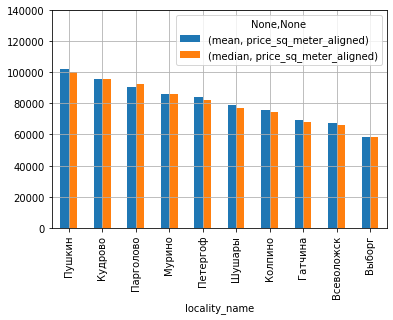

In [144]:
towns_price_pvt.sort_values(by=('mean','price_sq_meter_aligned'), ascending=False).plot(kind='bar',ylim=(0,140000))
plt.grid()

### Основные выводы и наблюдения

1. Следует четко понимать привязанность цены объявлений к дате и при определениях средних использовать только приведенную цену на 03-05-2019.

2. Мы имеем следующие параметры сегментации цен (сильная зависимость), позволяющие определить цену квадратного метра в нулевом приближении:
 * удаленность объекта (6 значений)
 * является ли однушкой (bool)
 * крайний ли этаж (bool)
 
3. По параметрам с неполными или малыми данными мы можем единообразно реализовать определение поправок к цене в первом приближении.  При этом для независимых параметров в первом приближении такие поправки линейно складываются.  Такими параметрами являются:
 * зеленая зона (4 значения)
 * прогулочная зона (bool)
 * балконы (4 значения - не реализовано)

4. По строительным параметрам (метражи, потолки, этажность, число комнат) не удается реализовать сегментацию цены по типам объектов, а просто брать производную по ним как по количественным параметрам и считать линейные поправки - это неверно: например, что лучше - большое соотношение жилой площади к общей или маленькое?  Очевидно лучше некоторое оптимальное, не слишком большое, не слишком маленькое, и мы опять приходим к типу объекта - говорят: "в этих квартирах маленькая прихожая, вся грязь несется прямо в комнаты" - зато какое большое соотношение жилой площади к общей!  

5. В крупных городах области цены такие же, как в спальных районах Питера, но уже на втором десятке цены опускаются на уровень средних в остальной области (всего более 300 населенных пунктов)


## Результат проекта - Калькулятор цен на конец первого полугодия 2019

По результатам проведенного проекта мы предлагаем следующую функцию определения стоимости квадратного метра:
$$ P = P_0(сегмент) + P_1(доп.параметры)$$

**Для определения рыночной цены P следует вызвать ниже определяемую цункцию P(remoteness, oneroom, lastfloor, green, walking, peter), где ее параметры означают:**
* remoteness:
 * `1-кат центр           -` 0-7 км (центральное кольцо города)
 * `2-кат спальные районы -` 7-17 км (Питер)
 * `3-кат окраина         -` > 17 км (Питер)
 * `4-кат пригород        -` < 35 км (не Питер)
 * `5-кат ближняя область -` 35-50 км 
 * `6-кат дальняя область -` > 50 км 
* oneroom:
 * `True                  -` однушка
 * `False                 -`
* lastfloor
 * `True                  -` первый или последний этах
 * `False                 -`
* green
 * `(0,1,2,3)             -` сумма парков и водоемов в радиусе 3км (если больше 3, то 3) и минус 1 за аэропорт в радиусе 5км
* walking
 * `True                  -` менее 500 метров до парка или водоема
 * `False                 -`
* piter
 * `True                  -` населенный пункт Питер
 * `False                 -`

In [145]:
def P_0(remoteness, oneroom, lastfloor):
    return data_df.query('(remote_cat==@remoteness) & (is_1room_cat==@oneroom) & (first_last_floor_cat==@lastfloor)')['price_sq_meter_aligned'].mean()

def P_1_percent(green, walking, piter):
    return (green_mile_corr_dict[green] + walking_corr_df.loc[walking,piter])

def P(remoteness, oneroom, lastfloor, green, walking, piter):
    return P_0(remoteness, oneroom, lastfloor) * ( 1 + P_1_percent(green, walking, piter) )

**Например:**

In [146]:
my_remoteness = '2-кат спальные районы'
my_oneroom = False 
my_lastfloor = False
my_green = 2
my_walking = True 
my_piter = True

my_price = P(my_remoteness, my_oneroom, my_lastfloor, my_green, my_walking, my_piter)
print(f'Рыночная стоимость Вашей квартиры на конец H1,2019: {int(my_price)} рублей за квадратный метр')

Рыночная стоимость Вашей квартиры на конец H1,2019: 119603 рублей за квадратный метр


## Конец проекта